In [1]:

import importlib
import data_prep as dp
import macro_utils
import pandas as pd
importlib.reload(dp) 
importlib.reload(macro_utils)
print(dir(dp))  # Check if functions appear now
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import numpy as np

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu
Device set to use cpu


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [561]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

# OPTIONAL: concat recent news with existing df for trading.

In [562]:
df_live = dp.macro_analysis('./../clean_macro_05-05-25_news.csv', 'description', 'title')

Step 1: Loading data


FileNotFoundError: [Errno 2] No such file or directory: './../clean_macro_05-05-25_news.csv'

In [2]:
#df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv') #adjust for live/most recent df news under /data/live
df = pd.read_csv('./../data/live/7y_up_to_05-06-25_news.csv')


In [3]:
df.index = pd.to_datetime(df['date'])
df = df.drop(columns=['date'])

In [4]:
df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161
2025-05-01,-0.214649,-0.976830,256,-0.123903,-0.974128,371,189,-0.169276,-0.975479,675,...,-0.246324,-1.002034,28.551781,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348
2025-05-02,-0.053660,-0.976696,177,-0.039443,-0.973332,387,147,-0.046552,-0.975014,744,...,-0.235076,-1.251975,28.172957,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362


In [ ]:
df_live.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_max,overall_pos_count,overall_neg_count,vix_target
12,2025-04-28,-0.096253,-0.975737,0.950602,152,90,0.048906,-0.971171,0.954707,192,50,-0.023674,-0.973454,0.952654,344,140,25.150000
13,2025-04-29,-0.256989,-0.975858,0.953012,282,247,-0.174279,-0.973403,0.952239,337,192,-0.215634,-0.974631,0.952625,619,439,24.170000
14,2025-04-30,-0.257138,-0.975998,0.953903,377,380,-0.172480,-0.976034,0.953903,439,318,-0.214809,-0.976016,0.953903,816,698,24.700001
15,2025-05-01,-0.214649,-0.976830,0.950811,304,256,-0.123903,-0.974128,0.950811,371,189,-0.169276,-0.975479,0.950811,675,445,24.600000
16,2025-05-02,-0.053660,-0.976696,0.954615,357,177,-0.039443,-0.973332,0.945728,387,147,-0.046552,-0.975014,0.950172,744,324,22.680000


In [3752]:
# Ensure 'date' columns are datetime
df['date'] = pd.to_datetime(df['date'])
df_live['date'] = pd.to_datetime(df_live['date'])

# Remove overlap: drop April 10 from df_live if it exists in df
df_live_trimmed = df_live[df_live['date'] > df['date'].max()]



In [3753]:
df_live_trimmed.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_max,overall_pos_count,overall_neg_count,vix_target
12,2025-04-28,-0.096253,-0.975737,0.950602,152,90,0.048906,-0.971171,0.954707,192,50,-0.023674,-0.973454,0.952654,344,140,25.150000
13,2025-04-29,-0.256989,-0.975858,0.953012,282,247,-0.174279,-0.973403,0.952239,337,192,-0.215634,-0.974631,0.952625,619,439,24.170000
14,2025-04-30,-0.257138,-0.975998,0.953903,377,380,-0.172480,-0.976034,0.953903,439,318,-0.214809,-0.976016,0.953903,816,698,24.700001
15,2025-05-01,-0.214649,-0.976830,0.950811,304,256,-0.123903,-0.974128,0.950811,371,189,-0.169276,-0.975479,0.950811,675,445,24.600000
16,2025-05-02,-0.053660,-0.976696,0.954615,357,177,-0.039443,-0.973332,0.945728,387,147,-0.046552,-0.975014,0.950172,744,324,22.680000


In [3754]:
df = pd.concat([df, df_live_trimmed], ignore_index=True)

In [749]:
df.to_csv('./../data/live/7y_up_to_05-06-25_news.csv', index=True)

In [750]:
df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161
2025-05-01,-0.214649,-0.976830,256,-0.123903,-0.974128,371,189,-0.169276,-0.975479,675,...,-0.246324,-1.002034,28.551781,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348
2025-05-02,-0.053660,-0.976696,177,-0.039443,-0.973332,387,147,-0.046552,-0.975014,744,...,-0.235076,-1.251975,28.172957,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362


In [751]:
df = df.drop(columns=['date.1'])

KeyError: "['date.1'] not found in axis"

In [752]:
df.tail()


,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161
2025-05-01,-0.214649,-0.976830,256,-0.123903,-0.974128,371,189,-0.169276,-0.975479,675,...,-0.246324,-1.002034,28.551781,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348
2025-05-02,-0.053660,-0.976696,177,-0.039443,-0.973332,387,147,-0.046552,-0.975014,744,...,-0.235076,-1.251975,28.172957,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362


In [3758]:
#df = pd.read_csv('./../data/live/7y_up_to_4_17_2025_news.csv')
df = macro_utils.calculate_stats(df, threshold_abs=9, window=30, window_prev=30)
df['vix_target'] = np.log(df['vix_target'])


In [3759]:
df.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
1915,2025-04-28,-0.096253,-0.975737,0.950602,152,90,0.048906,-0.971171,0.954707,192,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
1916,2025-04-29,-0.256989,-0.975858,0.953012,282,247,-0.174279,-0.973403,0.952239,337,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
1917,2025-04-30,-0.257138,-0.975998,0.953903,377,380,-0.172480,-0.976034,0.953903,439,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161
1918,2025-05-01,-0.214649,-0.976830,0.950811,304,256,-0.123903,-0.974128,0.950811,371,...,-0.246324,-1.002034,28.551781,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348
1919,2025-05-02,-0.053660,-0.976696,0.954615,357,177,-0.039443,-0.973332,0.945728,387,...,-0.235076,-1.251975,28.172957,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362


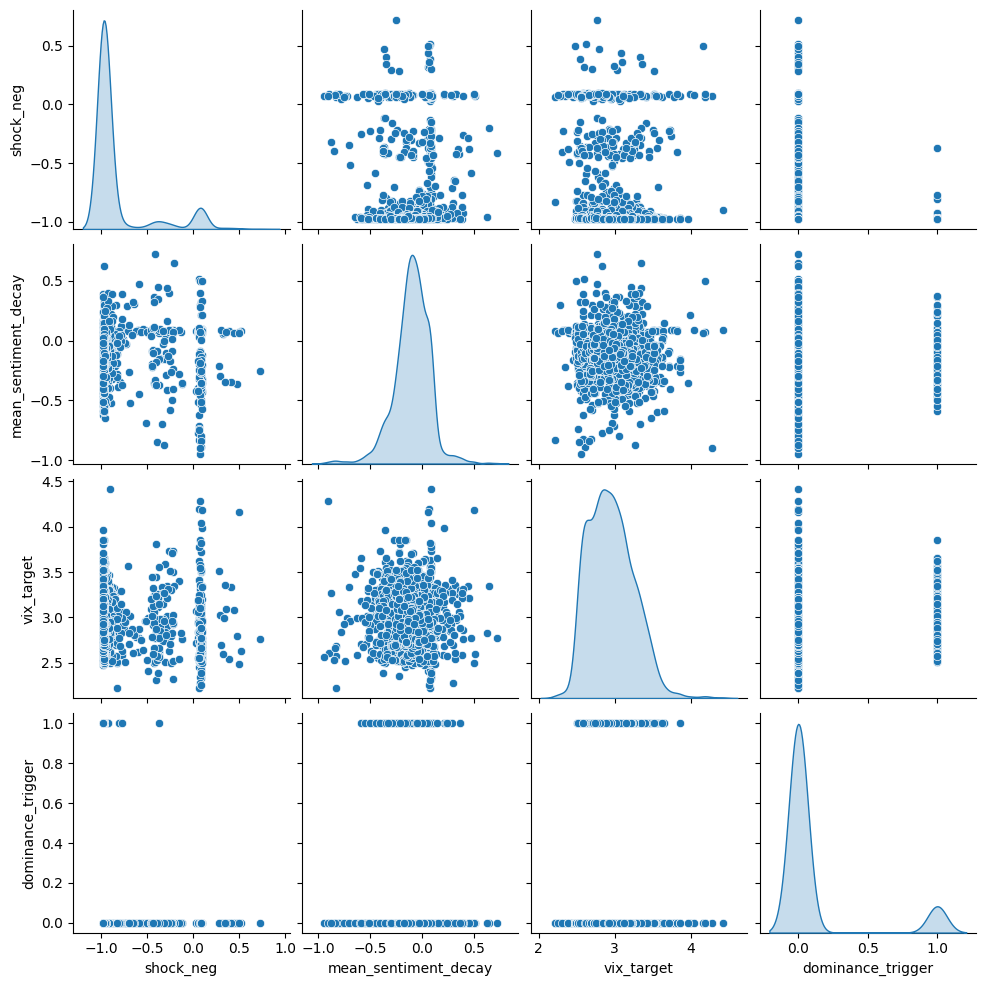

In [6]:
import seaborn as sns
sns.pairplot(df, vars=['shock_neg', 'mean_sentiment_decay', 'vix_target', 'dominance_trigger'], diag_kind='kde')


In [5]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]
selected_features = feature_sets[0]

In [6]:
df

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2017-12-13,0.086767,0.086767,0,-0.533592,-0.533592,0,2,-0.223413,-0.223413,2,...,NaN,NaN,10.180000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-14,0.091055,0.091055,0,0.091055,0.091055,1255,0,0.091055,0.091055,2510,...,NaN,NaN,10.340167,0.219203,0.683537,10.180000,10.180000,10.180000,NaN,NaN
2017-12-26,0.090923,0.090923,0,0.090923,0.090923,1,0,0.090923,0.090923,2,...,NaN,NaN,10.308086,0.161318,-0.360072,10.335000,10.335000,10.260084,0.109601,0.683537
2017-12-27,0.505010,0.060151,0,0.086224,0.082667,2,0,0.295617,0.071409,4,...,NaN,NaN,10.352699,0.154126,0.761071,10.306667,10.306667,10.276658,0.080952,0.370704
2018-01-02,0.065905,0.065905,0,0.085878,0.085878,1,0,0.075892,0.075892,2,...,NaN,NaN,10.220121,0.303267,-1.484241,10.347500,10.347500,10.296177,0.074564,0.688304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161


In [7]:
df.index = pd.to_datetime(df['date'])
df.tail()

KeyError: 'date'

In [ ]:
df = df.drop(columns=['date'])

In [ ]:
df = df.drop(columns=['summary_max', 'summary_pos_count', 'headline_max', 'overall_max', 'shock_pos'])

KeyError: "['summary_max', 'summary_pos_count', 'headline_max', 'overall_max', 'shock_pos'] not found in axis"

In [170]:
#df['vix_target_log'] = np.log(df['vix_target'])
#df['vix_target_log_ret'] = df['vix_target_log'].diff().dropna()

# Train: Post-COVID to end of 2023
#train_df = df[(df.index >= "2018-05-01") & (df.index <= "2024-10-15")]
train_df = df[(df.index <= "2024-10-15")]
# Test: Recent years
test_df = df[df.index >= "2024-10-16"]
print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[4] + ['vix_zscore']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_ewm_zscore_flat']


Train set: 1721 rows
Test set: 199 rows


In [171]:
X.isna().sum()
y.isna().sum()

np.int64(0)

In [172]:
train_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2017-12-13,0.086767,0.086767,0,-0.533592,-0.533592,0,2,-0.223413,-0.223413,2,...,NaN,NaN,10.180000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-14,0.091055,0.091055,0,0.091055,0.091055,1255,0,0.091055,0.091055,2510,...,NaN,NaN,10.340167,0.219203,0.683537,10.180000,10.180000,10.180000,NaN,NaN
2017-12-26,0.090923,0.090923,0,0.090923,0.090923,1,0,0.090923,0.090923,2,...,NaN,NaN,10.308086,0.161318,-0.360072,10.335000,10.335000,10.260084,0.109601,0.683537
2017-12-27,0.505010,0.060151,0,0.086224,0.082667,2,0,0.295617,0.071409,4,...,NaN,NaN,10.352699,0.154126,0.761071,10.306667,10.306667,10.276658,0.080952,0.370704
2018-01-02,0.065905,0.065905,0,0.085878,0.085878,1,0,0.075892,0.075892,2,...,NaN,NaN,10.220121,0.303267,-1.484241,10.347500,10.347500,10.296177,0.074564,0.688304


In [173]:
test_df_trade = test_df.copy()

In [174]:
test_df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161
2025-05-01,-0.214649,-0.976830,256,-0.123903,-0.974128,371,189,-0.169276,-0.975479,675,...,-0.246324,-1.002034,28.551781,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348
2025-05-02,-0.053660,-0.976696,177,-0.039443,-0.973332,387,147,-0.046552,-0.975014,744,...,-0.235076,-1.251975,28.172957,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362


In [175]:
percentile_markov = 0.001

In [176]:
transition_matrix, results, df_model = macro_utils.regime_t_markov_model(X, y, df_model, k=2, percentile=percentile_markov)

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [177]:
df_model.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,regime_t+1,regime_t+1_raw
date,,,,,,,,,,,,,,,,,,,,,
2024-10-11,-0.313376,-0.972448,58,-0.157393,-0.971905,57,48,-0.235385,-0.972176,104,...,0.501729,18.034666,18.034666,18.030169,1.283896,0.003503,0.065116,1,1.0,0.122250
2024-10-12,0.181630,-0.959148,9,0.054226,-0.946041,31,6,0.117928,-0.952595,59,...,0.211239,18.127000,18.127000,18.036416,1.242025,0.072932,0.122250,1,1.0,0.245281
2024-10-13,-0.280690,-0.969393,10,-0.232838,-0.916358,12,8,-0.256764,-0.942875,22,...,0.204007,18.214666,18.214666,18.047916,1.202117,0.138714,0.245281,1,1.0,0.495994
2024-10-14,0.009047,-0.974299,24,-0.044218,-0.972195,43,20,-0.017585,-0.973247,82,...,0.197043,18.319333,18.319333,18.065427,1.164669,0.218007,0.495994,1,1.0,0.787314
2024-10-15,-0.242439,-0.975493,63,-0.210137,-0.972273,74,56,-0.226288,-0.973883,141,...,0.556791,18.404667,18.404667,18.087313,1.129657,0.280929,0.787314,1,NaN,NaN


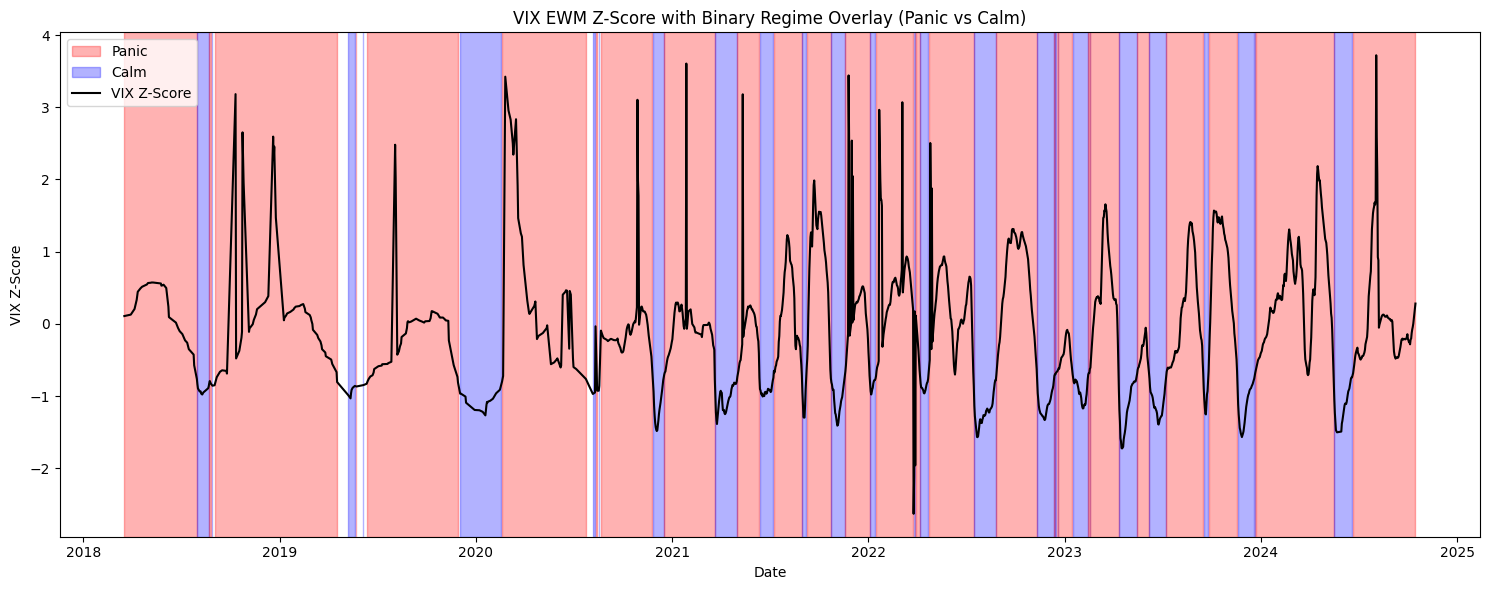

In [178]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_ewm_zscore_flat'], label='VIX_t (EWM Z-Score)', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.3)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.3)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX EWM Z-Score with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


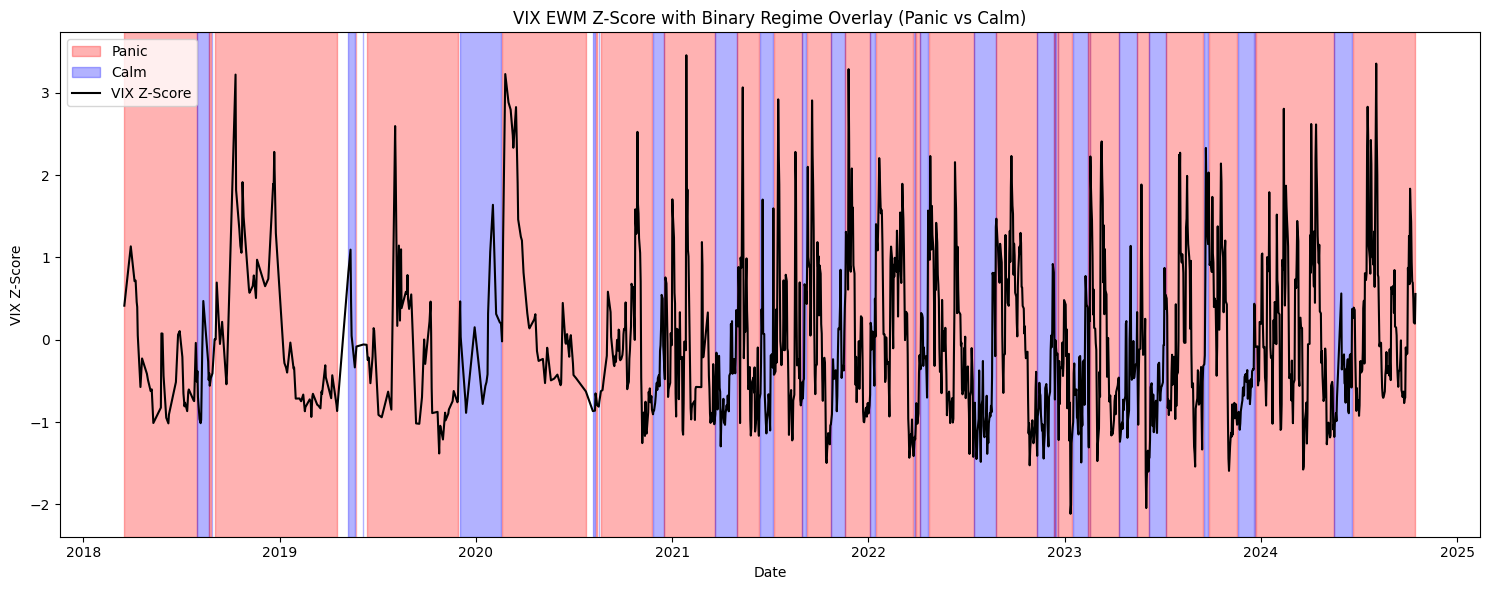

In [203]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_ewm_zscore'], label='VIX_t (Z-Score)', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.3)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.3)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX EWM Z-Score with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


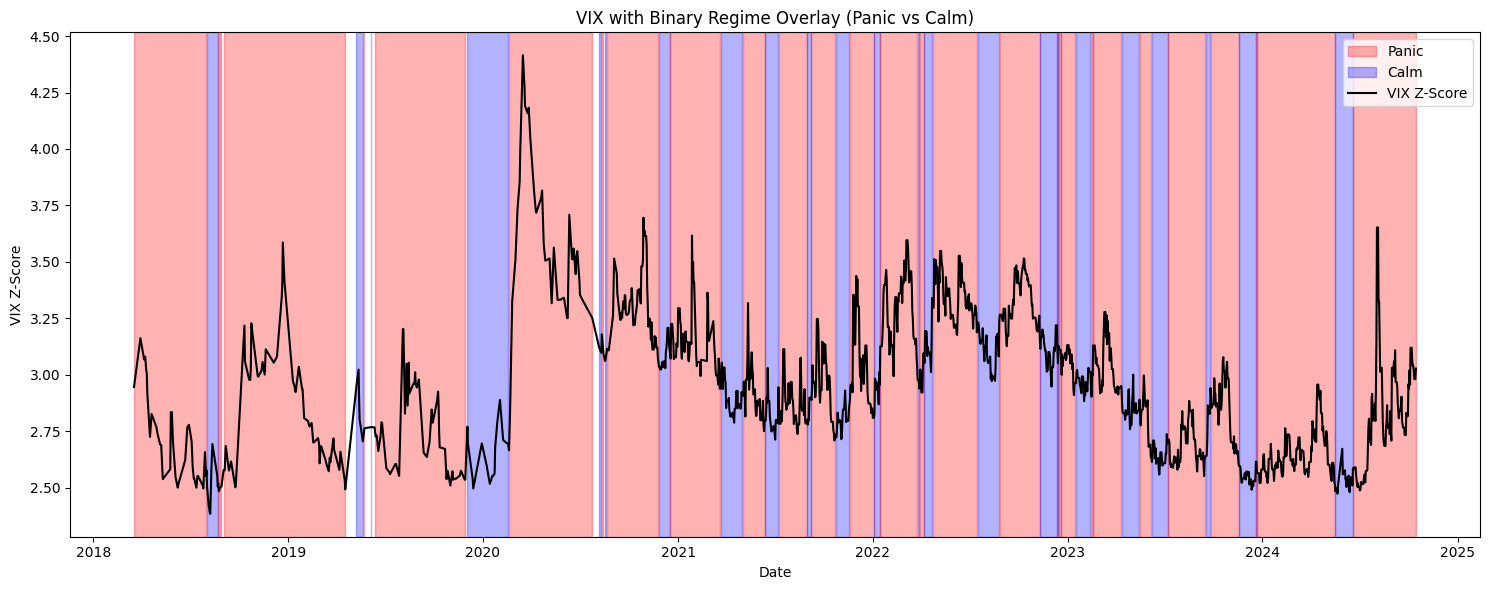

In [179]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_target'], label='VIX_t', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.3)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.3)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


In [88]:
df_model.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,regime_t+1,regime_t+1_raw
date,,,,,,,,,,,,,,,,,,,,,
2024-10-11,-0.313376,-0.972448,58,-0.157393,-0.971905,57,48,-0.235385,-0.972176,104,...,0.501729,18.034666,18.034666,18.030169,1.283896,0.003503,0.065116,1,1.0,0.122250
2024-10-12,0.181630,-0.959148,9,0.054226,-0.946041,31,6,0.117928,-0.952595,59,...,0.211239,18.127000,18.127000,18.036416,1.242025,0.072932,0.122250,1,1.0,0.245281
2024-10-13,-0.280690,-0.969393,10,-0.232838,-0.916358,12,8,-0.256764,-0.942875,22,...,0.204007,18.214666,18.214666,18.047916,1.202117,0.138714,0.245281,1,1.0,0.495994
2024-10-14,0.009047,-0.974299,24,-0.044218,-0.972195,43,20,-0.017585,-0.973247,82,...,0.197043,18.319333,18.319333,18.065427,1.164669,0.218007,0.495994,1,1.0,0.787314
2024-10-15,-0.242439,-0.975493,63,-0.210137,-0.972273,74,56,-0.226288,-0.973883,141,...,0.556791,18.404667,18.404667,18.087313,1.129657,0.280929,0.787314,1,NaN,NaN


In [89]:
df_model = df_model.dropna()

In [90]:
clf, y_pred, classification_df = macro_utils.clf_panic_tomorrow(df_model, selected_features, 'regime_t+1')

              precision    recall  f1-score   support

         0.0       1.00      0.04      0.08       429
         1.0       0.75      1.00      0.86      1262

    accuracy                           0.76      1691
   macro avg       0.88      0.52      0.47      1691
weighted avg       0.82      0.76      0.66      1691



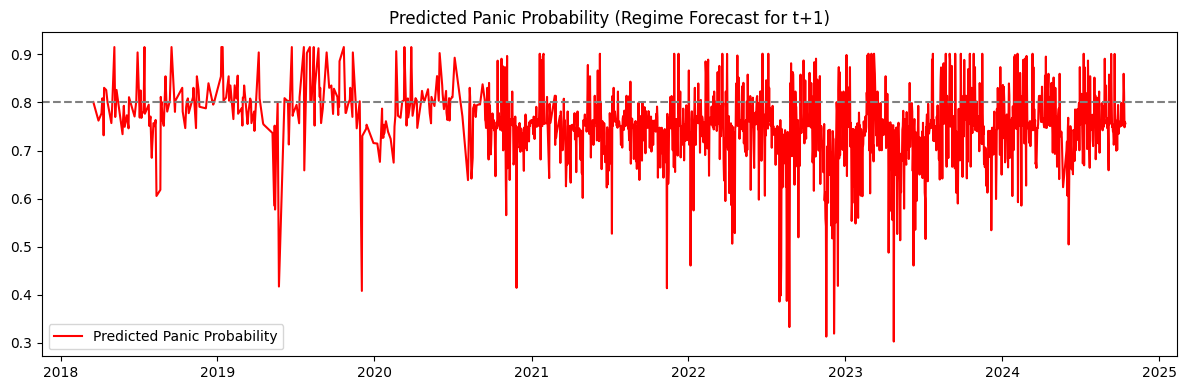

In [91]:
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, df_model['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.8, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


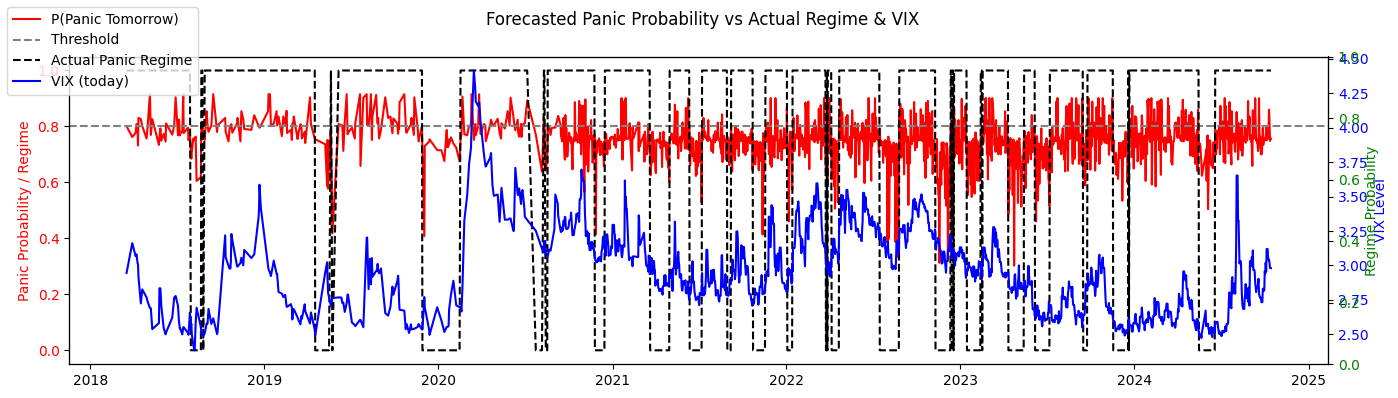

In [92]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.8, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
#ax3.plot(classification_df.index, classification_df['regime_t_raw'], label='Regime Probability', color='green')
ax3.set_ylabel("Regime Probability", color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


for each regime=1, we now get the set of days aferwards to see how vix behaves as soon as the model changes regime

In [93]:

classification_df = macro_utils.identify_sustained_regimes_and_transitions(classification_df)

In [94]:
classification_df['is_transition'].value_counts()

is_transition
False    1663
True       28
Name: count, dtype: int64

In [95]:
classification_df['regime_t']

date
2018-03-18    1
2018-03-30    1
2018-04-06    1
2018-04-08    1
2018-04-10    1
             ..
2024-10-10    1
2024-10-11    1
2024-10-12    1
2024-10-13    1
2024-10-14    1
Name: regime_t, Length: 1691, dtype: int64

In [96]:

# Usage Example:
result = macro_utils.transform_vix_data(classification_df, window=60, k=2)
vix_windows_df_train = result["vix_windows_df_train"]
regime_windows_df_train = result["regime_windows_df_train"]
vix_windows_past_df_train = result["vix_windows_past_df_train"]


In [97]:
regime_windows_df_train.shape

(26, 60)

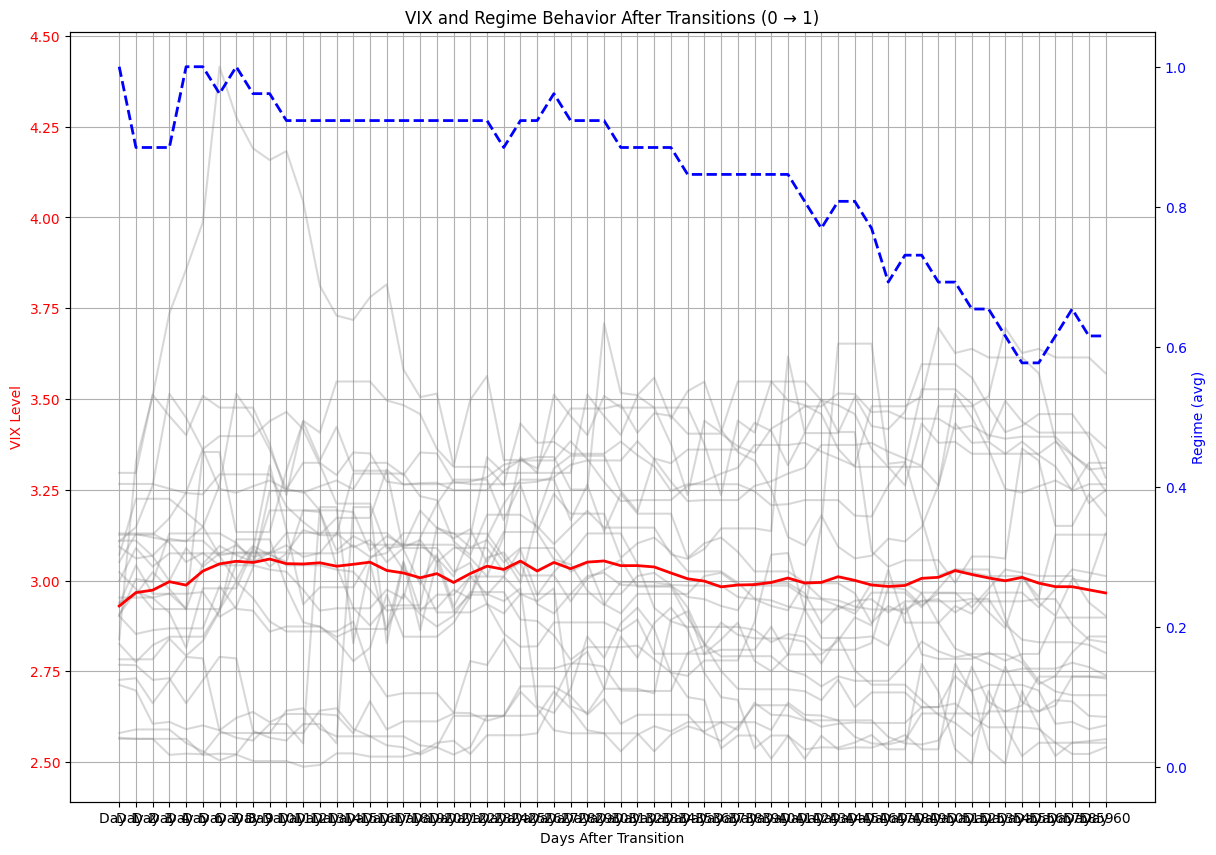

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_train.T, color="gray", alpha=0.3, label="Individual VIX transitions")
ax1.plot(vix_windows_df_train.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_train.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
#plt.tight_layout()
plt.show()



since some spikes happen quite some time after the regime switches, we will build a classifier for 0 (immediate) or 1 (delayed), then feed this into a model for vix level forecasting

In [99]:
vix_windows_past_df_train.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2019-05-24,2.684440,2.575661,2.615935,2.501436,2.519308,3.218075,3.059176,2.998728,2.977568,2.977568,...,2.578701,2.658860,2.533697,2.492379,2.949688,3.022861,2.893700,2.799717,2.770086,2.704711
2019-06-12,2.615935,2.501436,2.519308,3.218075,3.059176,2.998728,2.977568,2.977568,3.030617,3.228034,...,2.533697,2.492379,2.949688,3.022861,2.893700,2.799717,2.770086,2.704711,2.763170,2.768204
2020-02-19,2.586259,2.567254,2.559550,2.604909,2.604909,2.551786,3.202340,3.202340,2.827905,3.048799,...,2.553344,2.553344,2.558002,2.563410,2.678278,2.789937,2.888704,2.710713,2.696652,2.696652
2020-08-11,2.694627,2.536075,2.496506,2.695978,2.598979,2.516890,2.553344,2.553344,2.553344,2.558002,...,3.558771,3.445852,3.521644,3.547604,3.415429,3.354106,3.330059,3.251924,3.120160,3.096934
2020-08-21,2.598979,2.516890,2.553344,2.553344,2.553344,2.558002,2.563410,2.678278,2.789937,2.888704,...,3.415429,3.354106,3.330059,3.251924,3.120160,3.096934,3.179303,3.093313,3.061052,3.068518


In [100]:
vix_windows_df_train.iloc[-1].max()

np.float64(3.652474764307879)

In [101]:
df_delayed_spike_prob, clf_delayed_spike_prob, vix_pct_change_lookback_df_train = macro_utils.clf_delayed_spike_prob(vix_windows_df_train, df_model, "vix_target")

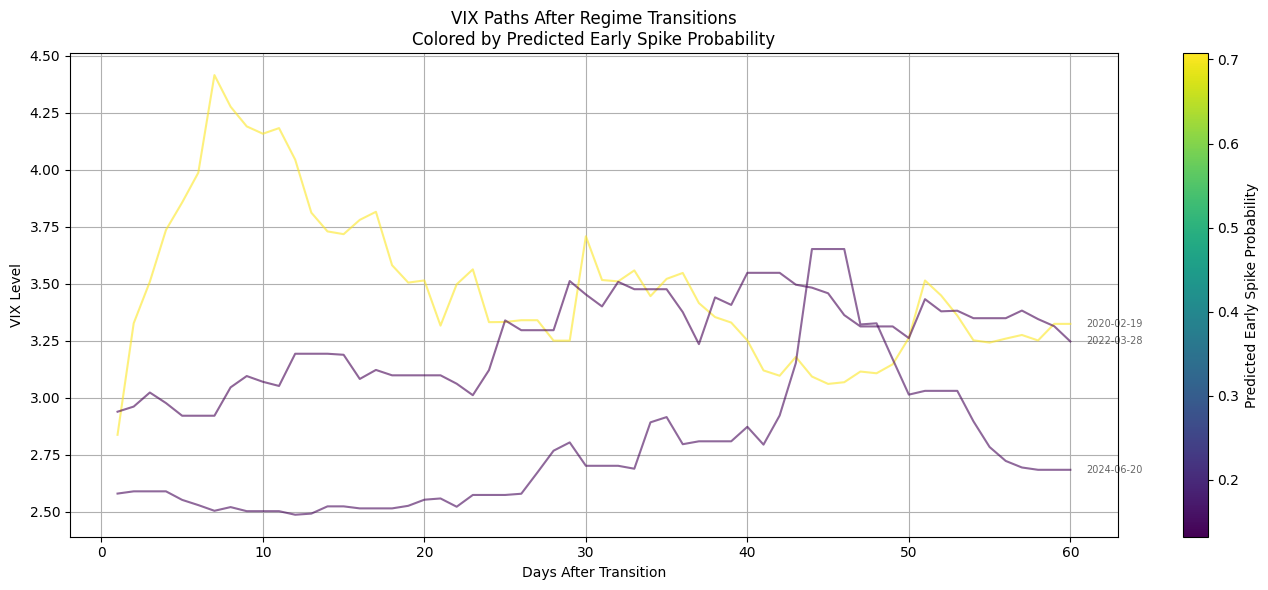

In [102]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [103]:
classification_df['regime_t'].value_counts()

regime_t
1    1262
0     429
Name: count, dtype: int64

We will now predict whether the regime switch is a spike or not

because of randomness, we will just predict peak, half decay time, and rising time.

In [104]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news = train_df.copy()                       # original df you posted   # string/ts column → index
news = news.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()


    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats = engineer_news_feats(news)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats.index = pd.to_datetime(news_feats.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats.index.min(),
                          news_feats.index.max(),
                          freq='D')

news_dense = (
    news_feats
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



C:\Users\dsuni\AppData\Local\Temp\ipykernel_21156\37269508.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()                 # carry last known sentiment forward


In [105]:
train_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2017-12-13,0.086767,0.086767,0,-0.533592,-0.533592,0,2,-0.223413,-0.223413,2,...,NaN,NaN,10.180000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-14,0.091055,0.091055,0,0.091055,0.091055,1255,0,0.091055,0.091055,2510,...,NaN,NaN,10.340167,0.219203,0.683537,10.180000,10.180000,10.180000,NaN,NaN
2017-12-26,0.090923,0.090923,0,0.090923,0.090923,1,0,0.090923,0.090923,2,...,NaN,NaN,10.308086,0.161318,-0.360072,10.335000,10.335000,10.260084,0.109601,0.683537
2017-12-27,0.505010,0.060151,0,0.086224,0.082667,2,0,0.295617,0.071409,4,...,NaN,NaN,10.352699,0.154126,0.761071,10.306667,10.306667,10.276658,0.080952,0.370704
2018-01-02,0.065905,0.065905,0,0.085878,0.085878,1,0,0.075892,0.075892,2,...,NaN,NaN,10.220121,0.303267,-1.484241,10.347500,10.347500,10.296177,0.074564,0.688304


In [106]:
vix_windows_df_train

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2019-05-24,2.768204,2.766948,2.726545,2.731115,2.662355,2.725235,2.789937,2.785628,2.586259,2.567254,...,2.694627,2.536075,2.496506,2.695978,2.598979,2.516890,2.553344,2.553344,2.553344,NaN
2019-06-12,2.726545,2.731115,2.662355,2.725235,2.789937,2.785628,2.586259,2.567254,2.559550,2.604909,...,2.496506,2.695978,2.598979,2.516890,2.553344,2.553344,2.553344,2.558002,2.563410,NaN
2020-02-19,2.837908,3.326833,3.509154,3.736240,3.856510,3.987131,4.415099,4.276666,4.190261,4.158102,...,3.448717,3.360723,3.252311,3.242202,3.259634,3.275634,3.251537,3.324316,3.324316,0.7075
2020-08-11,3.093313,3.061052,3.068518,3.115292,3.107721,3.147165,3.262701,3.514526,3.448717,3.360723,...,3.480009,3.507058,3.695855,3.626738,3.638112,3.614425,3.614425,3.614425,3.570940,NaN
2020-08-21,3.107721,3.147165,3.262701,3.514526,3.448717,3.360723,3.252311,3.242202,3.259634,3.275634,...,3.638112,3.614425,3.614425,3.614425,3.570940,3.386760,3.317091,3.213260,3.248435,NaN
2020-12-17,3.071303,3.225255,3.225255,3.225255,3.187592,3.148882,3.069447,3.077312,3.077312,3.077312,...,3.066191,3.066191,3.060583,3.363495,3.330417,3.150597,3.150597,3.237501,3.179303,NaN
2021-05-02,2.907447,2.969388,2.952303,2.911807,2.814810,2.978586,2.978586,2.978586,3.083743,3.317453,...,2.792391,2.770712,2.748552,2.757475,2.757475,2.757475,2.773838,2.761907,2.739549,NaN
2021-07-09,2.783158,2.783158,2.783158,2.840247,2.793004,2.833801,2.915064,3.113515,3.113515,3.113515,...,2.784394,2.802147,2.779440,2.797891,2.797891,2.898119,2.898119,2.898119,2.898119,NaN
2021-09-08,2.933857,3.042139,2.963726,2.963726,2.963726,2.968361,2.900322,2.927989,3.035434,3.246880,...,2.797891,2.797891,2.797891,2.774462,2.714695,2.736962,2.802147,2.846071,2.846071,NaN


In [107]:
# ------------------------------------------------------------
# 3)  BUILD ARC-LEVEL TABLE  (robust to missing news dates + look-back stats)
# ------------------------------------------------------------
records = []
lookback_days = [2, 5, 7]
lookback_feats = [
    "shock_neg",
    "vix_zscore",
    "vix_target",
    "sentiment_dominance",

]

for dt, row in vix_windows_df_train.iterrows():
    # --- detect arc in the 60-day window ---
    v = row[[f"Day {i}" for i in range(1, 61)]].values
    r = regime_windows_df_train.loc[dt, [f"Day {i}" for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    print(start_idx, peak_idx)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur = peak_idx - start_idx
    decay_idx = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest-past news features --------
    try:
        feats_on_start = news_dense.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    # -------- compute look-back statistics from classification_df --------
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df.loc[start_date:dt_norm]

        for feat in lookback_feats:
            col_mean = window_df[feat].mean()
            col_std = window_df[feat].std()
            # percent change over the window: (last−first) / first
            if len(window_df) > 1 and window_df[feat].iloc[0] != 0:
                col_pct = (window_df[feat].iloc[-1] - window_df[feat].iloc[0]) / window_df[feat].iloc[0]
            else:
                col_pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"] = col_mean
            lookback_stats[f"{feat}_std_{w}d"]  = col_std
            lookback_stats[f"{feat}_pctchg_{w}d"] = col_pct

    # --- aggregate everything into one record ---
    records.append({
        "date_start":    dt_norm,
        "peak_vix":      peak_val,
        "vix0":          start_val,
        "T_up":          rise_dur,
        "T_half":        half_life,
        **feats_on_start,
        **lookback_stats,
    })

arc_df = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)

0 0
0 12
0 6
0 1
34 49
0 40
0 9
0 7
0 9
0 11
40 48
0 0
0 6
0 13
0 43
0 1
0 0
0 10
0 1
12 20
0 7
0 36
14 23
0 0
0 51
32 43
arc_df shape: (26, 68)


In [108]:
arc_df['early_spike_prob'] = vix_windows_df_train['early_spike_prob'].fillna(0.5)

In [109]:
arc_df = arc_df.dropna()

In [110]:
arc_df = arc_df.drop(columns=['vix_target'])

In [111]:
len(arc_df)

22

In [112]:
arc_df['delta_peak'] = arc_df['peak_vix'] - arc_df['vix0']
arc_df['spike5d'] = (arc_df['delta_peak'] > 0.1 * arc_df['vix0']).astype(int)

In [113]:
arc_df

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d
date_start,,,,,,,,,,,,,,,,,,,,,
2020-02-19,4.415099,2.837908,6.0,54.0,0.078960,0.078960,0.0,0.089487,0.089487,1.0,...,-0.416727,2.686381,0.017790,-0.011427,1.000000,2.000000,-0.666667,0.7075,1.577191,1
2020-08-11,3.061052,3.093313,1.0,59.0,0.050000,0.050000,0.0,0.089418,0.089418,2.0,...,-0.134013,3.132132,0.042470,0.018955,0.666667,1.527525,1.000000,0.5000,-0.032261,0
2020-12-17,3.616578,3.071303,40.0,20.0,-0.033229,-0.971132,145.0,-0.051390,-0.964359,449.0,...,-1.306063,3.152274,0.048917,-0.008524,161.375000,116.327048,0.602941,0.5000,0.545274,1
2021-05-02,3.317453,2.907447,9.0,51.0,-0.145972,-0.936570,8.0,0.001964,-0.902733,18.0,...,-8.407874,2.882822,0.026221,0.012988,14.125000,24.948161,1.333333,0.5000,0.410006,1
2021-07-09,3.113515,2.783158,7.0,53.0,0.220176,-0.864469,9.0,0.196445,-0.943447,48.0,...,-0.718838,2.803100,0.064247,0.026199,50.500000,45.302160,-0.755102,0.5000,0.330358,1
2021-09-08,3.246880,2.933857,9.0,51.0,-0.091355,-0.975042,98.0,-0.041849,-0.972005,203.0,...,-1.699498,2.856981,0.054428,0.039111,45.750000,31.143676,4.666667,0.5000,0.313023,1
2021-11-19,3.437851,2.953347,11.0,49.0,-0.073962,-0.969612,49.0,0.026695,-0.964625,85.0,...,-46.258655,2.823327,0.036198,0.033975,10.875000,13.943124,-3.200000,0.5000,0.484504,1
2022-01-15,3.595941,3.317453,8.0,12.0,-0.248970,-0.926648,1.0,0.085081,0.082906,3.0,...,11.774883,2.971197,0.075481,0.054312,3.750000,12.441291,-0.750000,0.5000,0.278488,0
2022-03-28,2.939162,2.939162,0.0,60.0,-0.155818,-0.974461,257.0,-0.073596,-0.972532,449.0,...,-0.116508,3.061709,0.081448,-0.057379,95.000000,45.791453,0.192661,0.1325,0.000000,0


In [117]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import itertools
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error


mlp_hidden_layer_sizes = list(itertools.product(range(5, 25), repeat=2))


# --- your DataFrame and columns ---
# arc_df: pandas DataFrame already in scope
target_cols  = ["peak_vix", "T_up", "T_half", "delta_peak", 'spike5d']
feature_cols = arc_df.columns.difference(target_cols)
X_full       = arc_df[feature_cols].values
y_full       = arc_df[target_cols].values

# --- CV and scoring setup ---
tscv       = TimeSeriesSplit(n_splits=10)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ============================================================
# 1)  HYPERPARAMETER GRIDS
# ============================================================
param_grid_default = {
    "mlp__hidden_layer_sizes": [(10, 5), (20, 10), (15, 10), (12, 8), (16, 10), (20,15), (25, 10), (25,15), (25,20)],
    "mlp__alpha":              [0.1, 1.0,1.5, 1.6, 1.7, 1.8, 1.9, 1.4, 1.3, 1.2, 1.1],
    "mlp__learning_rate_init": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0.005, 0.0005],
}
param_grid_delta = {
    "mlp__hidden_layer_sizes": [(10, 5), (20, 10), (15, 10), (12, 8), (16, 10), (20,15), (25, 10), (25,15), (25,20)],
    "mlp__alpha":              [0.1, 1.0,1.5, 1.6, 1.7, 1.8, 1.9, 1.4, 1.3, 1.2, 1.1],
    "mlp__learning_rate_init": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 0.005, 0.0005],
}

models = {}
cv_mae = {}

# ============================================================
# 2)  GRID-SEARCH + FINAL FIT PER TARGET
# ============================================================
for col in target_cols:
    y = y_full[:, target_cols.index(col)]
    is_delta = (col == "delta_peak")

    # 2a) base pipeline: scale X → MLP
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("mlp", MLPRegressor(
            solver="adam",
            activation="tanh",
            max_iter=10000,
            random_state=38
        ))
    ])

    # 2b) wrap with a QuantileTransformer on y
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=QuantileTransformer(
            n_quantiles=10,
            output_distribution="normal",
            random_state=38
        )
    )

    # 2c) GridSearchCV over the inner regressor
    grid = GridSearchCV(
        estimator=pipe.regressor,
        param_grid=(param_grid_delta if is_delta else param_grid_default),
        cv=tscv,
        scoring=mae_scorer,
        n_jobs=-1,
        verbose=1
    )

    # 2d) wrap back into TransformedTargetRegressor
    grid_pipe = TransformedTargetRegressor(
        regressor=grid,
        transformer=pipe.transformer
    )

    # run the grid-search
    print(f"\n>>> Grid‐searching hyperparams for '{col}' …")
    grid_pipe.fit(X_full, y)

    # pull tuned hyperparameters & CV score from the fitted GridSearchCV
    best_params = grid_pipe.regressor_.best_params_
    best_score  = grid_pipe.regressor_.best_score_
    print(f"Best params for {col}: {best_params}")
    print(f"Best CV MAE (10‐fold avg): {-best_score:.3f}")

    # 2e) build final model on all data using best_params
    print(f"Fitting final '{col}' model on all data …")
    mlp_kwargs = {k.replace("mlp__", ""): v for k, v in best_params.items()}
    final_pipe = TransformedTargetRegressor(
        regressor=Pipeline([
            ("scale_X", StandardScaler()),
            ("mlp", MLPRegressor(
                **mlp_kwargs,
                solver="adam",
                activation="tanh",
                max_iter=10000,
                random_state=38
            ))
        ]),
        transformer=pipe.transformer
    )
    final_pipe.fit(X_full, y)
    models[col] = final_pipe

    # quick CV to report final MAE
    perf = -np.mean(
        cross_validate(
            final_pipe, X_full, y,
            cv=tscv,
            scoring=mae_scorer,
            return_train_score=False,
            n_jobs=-1
        )["test_score"]
    )
    cv_mae[col] = perf
    print(f"{col:12s} | Final MAE (10-fold): {perf:.3f}")

    # save the trained pipeline
    joblib.dump(final_pipe, f"mlp_{col}.pkl")

# ============================================================
# 3)  SUMMARY
# ============================================================
print("\nSaved models:", list(models.keys()))
print("CV MAEs:", cv_mae)




>>> Grid‐searching hyperparams for 'peak_vix' …
Fitting 10 folds for each of 792 candidates, totalling 7920 fits
Best params for peak_vix: {'mlp__alpha': 1.0, 'mlp__hidden_layer_sizes': (10, 5), 'mlp__learning_rate_init': 0.3}
Best CV MAE (10‐fold avg): 0.919
Fitting final 'peak_vix' model on all data …
peak_vix     | Final MAE (10-fold): 0.339

>>> Grid‐searching hyperparams for 'T_up' …
Fitting 10 folds for each of 792 candidates, totalling 7920 fits
Best params for T_up: {'mlp__alpha': 1.6, 'mlp__hidden_layer_sizes': (20, 15), 'mlp__learning_rate_init': 0.3}
Best CV MAE (10‐fold avg): 1.656
Fitting final 'T_up' model on all data …
T_up         | Final MAE (10-fold): 19.597

>>> Grid‐searching hyperparams for 'T_half' …
Fitting 10 folds for each of 792 candidates, totalling 7920 fits
Best params for T_half: {'mlp__alpha': 1.8, 'mlp__hidden_layer_sizes': (16, 10), 'mlp__learning_rate_init': 0.3}
Best CV MAE (10‐fold avg): 1.553
Fitting final 'T_half' model on all data …
T_half       

In [118]:
arc_df

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d
date_start,,,,,,,,,,,,,,,,,,,,,
2020-02-19,4.415099,2.837908,6.0,54.0,0.078960,0.078960,0.0,0.089487,0.089487,1.0,...,-0.416727,2.686381,0.017790,-0.011427,1.000000,2.000000,-0.666667,0.7075,1.577191,1
2020-08-11,3.061052,3.093313,1.0,59.0,0.050000,0.050000,0.0,0.089418,0.089418,2.0,...,-0.134013,3.132132,0.042470,0.018955,0.666667,1.527525,1.000000,0.5000,-0.032261,0
2020-12-17,3.616578,3.071303,40.0,20.0,-0.033229,-0.971132,145.0,-0.051390,-0.964359,449.0,...,-1.306063,3.152274,0.048917,-0.008524,161.375000,116.327048,0.602941,0.5000,0.545274,1
2021-05-02,3.317453,2.907447,9.0,51.0,-0.145972,-0.936570,8.0,0.001964,-0.902733,18.0,...,-8.407874,2.882822,0.026221,0.012988,14.125000,24.948161,1.333333,0.5000,0.410006,1
2021-07-09,3.113515,2.783158,7.0,53.0,0.220176,-0.864469,9.0,0.196445,-0.943447,48.0,...,-0.718838,2.803100,0.064247,0.026199,50.500000,45.302160,-0.755102,0.5000,0.330358,1
2021-09-08,3.246880,2.933857,9.0,51.0,-0.091355,-0.975042,98.0,-0.041849,-0.972005,203.0,...,-1.699498,2.856981,0.054428,0.039111,45.750000,31.143676,4.666667,0.5000,0.313023,1
2021-11-19,3.437851,2.953347,11.0,49.0,-0.073962,-0.969612,49.0,0.026695,-0.964625,85.0,...,-46.258655,2.823327,0.036198,0.033975,10.875000,13.943124,-3.200000,0.5000,0.484504,1
2022-01-15,3.595941,3.317453,8.0,12.0,-0.248970,-0.926648,1.0,0.085081,0.082906,3.0,...,11.774883,2.971197,0.075481,0.054312,3.750000,12.441291,-0.750000,0.5000,0.278488,0
2022-03-28,2.939162,2.939162,0.0,60.0,-0.155818,-0.974461,257.0,-0.073596,-0.972532,449.0,...,-0.116508,3.061709,0.081448,-0.057379,95.000000,45.791453,0.192661,0.1325,0.000000,0


c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


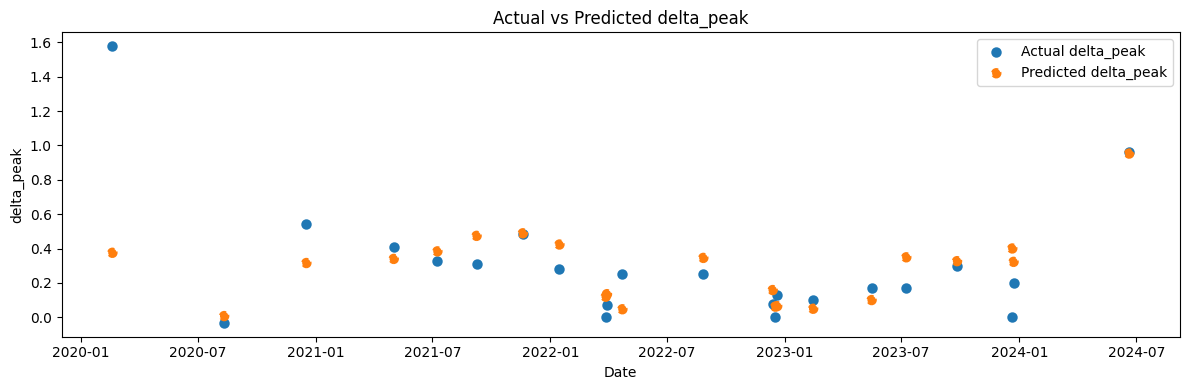

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


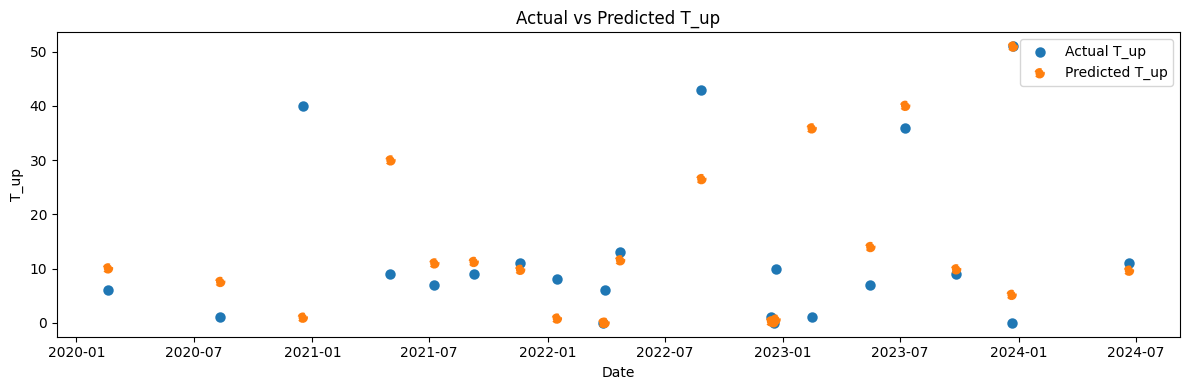

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


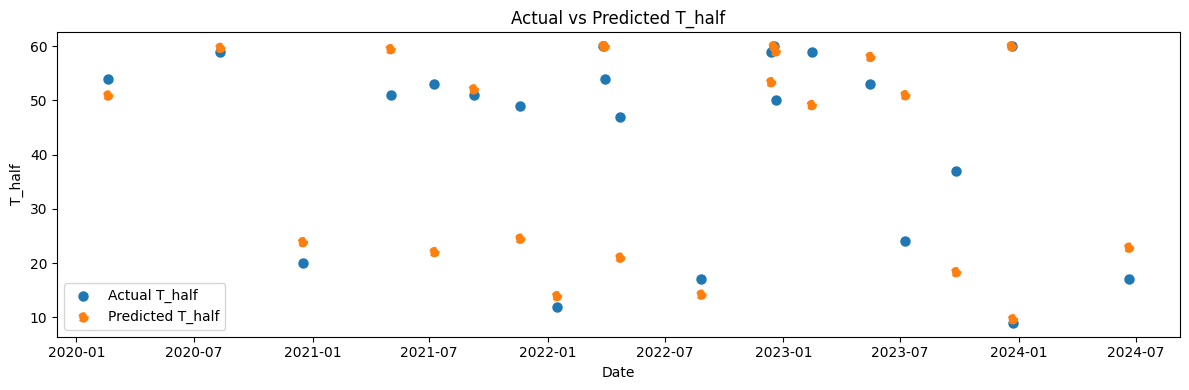

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


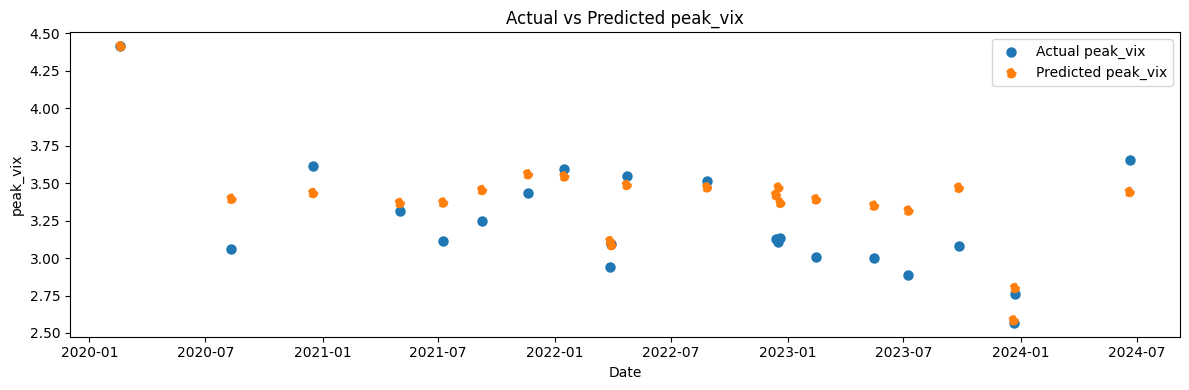

In [119]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["delta_peak", "T_up", "T_half", 'peak_vix', 'spike5d'])

X_full_test = arc_df.reindex(columns=feature_cols)
X_full_test = X_full_test.fillna(0)

dates = arc_df.index         # x‑axis

models = {
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [447]:
import pandas as pd

# 1) Prepare your inputs & models (as you already have)
feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half", "delta_peak", 'spike5d'])
X_full       = arc_df[feature_cols].values
dates        = arc_df.index

models = {
    "peak_vix":   joblib.load("mlp_peak_vix.pkl"),
    "T_up":       joblib.load("mlp_T_up.pkl"),
    "T_half":     joblib.load("mlp_T_half.pkl"),
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
}

# 2) Build the predictions DataFrame
pred_df = pd.DataFrame(index=dates)

for target, model in models.items():
    y_pred = model.predict(X_full)
    pred_df[f"nn_{target}"] = y_pred

# 3) (Optional) peek at the first few rows
print(pred_df.head())

# 4) (Optional) join back to your original DataFrame
arc_df_with_nn = arc_df.join(pred_df)


            nn_peak_vix    nn_T_up  nn_T_half  nn_delta_peak
date_start                                                  
2020-02-19     4.414533  10.043357  50.903302       0.375433
2020-08-11     3.395488   7.546899  59.684250       0.007251
2020-12-17     3.434185   0.960079  23.877727       0.315896
2021-05-02     3.367566  29.947083  59.438708       0.339930
2021-07-09     3.370859  10.962915  22.037646       0.383706


c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


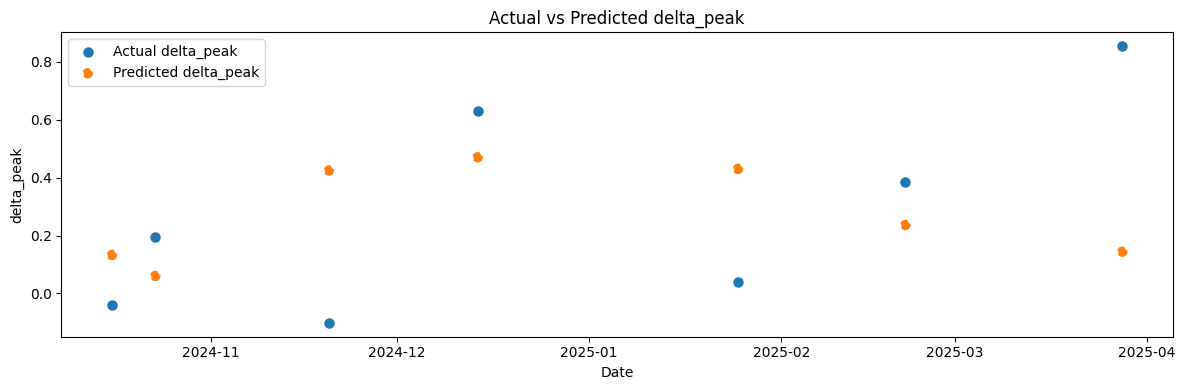

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


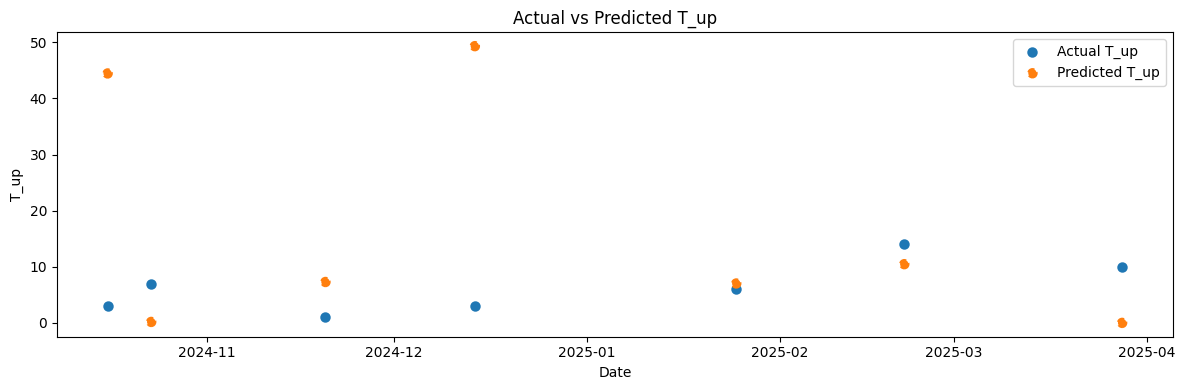

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


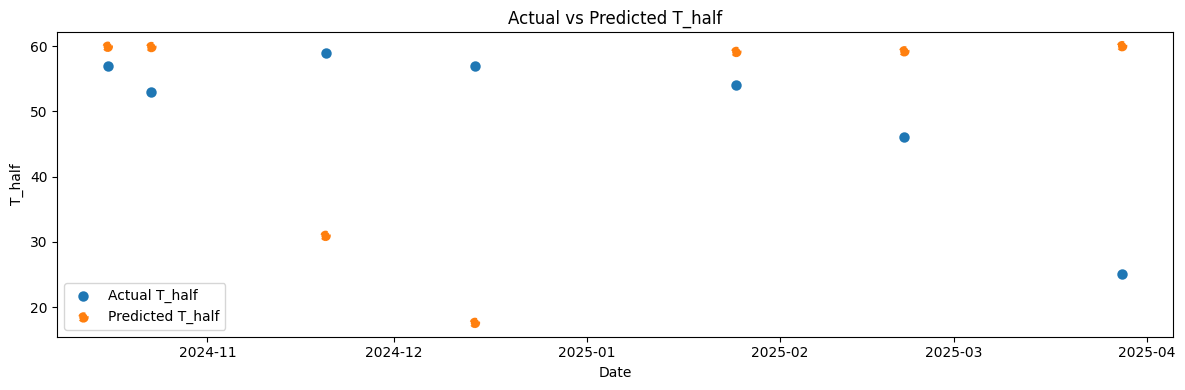

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


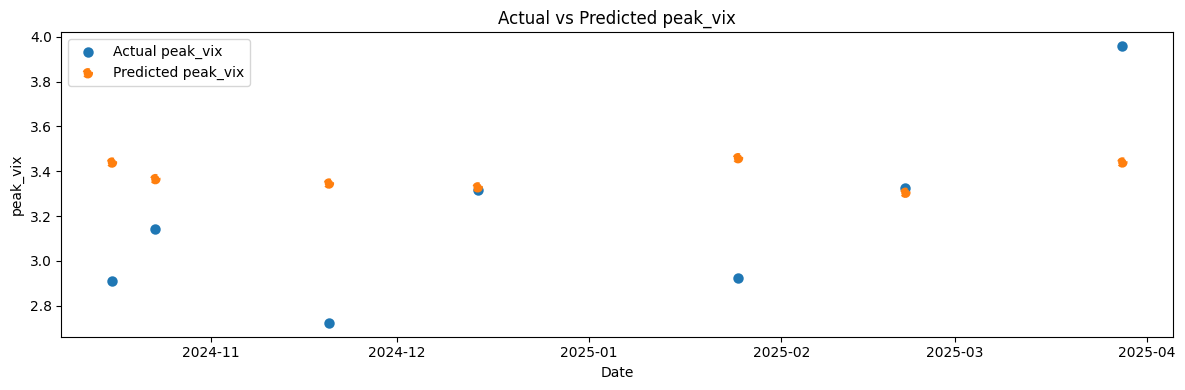

In [448]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["delta_peak", "T_up", "T_half", 'peak_vix', 'spike5d'])

X_full_test = arc_df_test.reindex(columns=feature_cols)
X_full_test = X_full_test.fillna(0)

dates = arc_df_test.index         # x‑axis

models = {
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
}

pred_df_test = pd.DataFrame(index=dates)


# 4) (Optional) join back to your original DataFrame
arc_df_with_nn = arc_df.join(pred_df)

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)
    pred_df_test[f"nn_{target}"] = y_pred_test


    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [449]:
pred_df_test.tail()
arc_df_with_nn_test = arc_df_test.join(pred_df_test)


In [450]:
arc_df_with_nn_test.tail()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d,nn_delta_peak,nn_T_up,nn_T_half,nn_peak_vix
date_start,,,,,,,,,,,,,,,,,,,,,
2024-11-20,2.723924,2.825537,1.0,59.0,-0.033441,-0.974451,53.0,0.014901,-0.973305,105.0,...,33.875,17.963753,0.538462,0.5000,-0.101613,0,0.424493,7.293268,30.909411,3.345124
2024-12-14,3.318540,2.687167,3.0,57.0,-0.078451,-0.957540,22.0,-0.030820,-0.951946,65.0,...,63.125,29.112773,-0.220000,0.2125,0.631373,1,0.470305,49.314358,17.563984,3.328199
2025-01-25,2.924236,2.884801,6.0,54.0,0.117867,-0.971038,7.0,0.201732,-0.680292,15.0,...,8.500,15.212777,-0.454545,0.5000,0.039436,0,0.430083,7.024296,59.116955,3.458150
2025-02-21,3.327192,2.943386,14.0,46.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,29.750,17.458113,-0.519231,0.2300,0.383806,1,0.236437,10.466015,59.214366,3.304078
2025-03-28,3.957570,3.103689,10.0,25.0,-0.162400,-0.970411,129.0,-0.077482,-0.974197,228.0,...,77.625,38.059868,-0.241758,0.2175,0.853880,1,0.144250,0.006474,59.999885,3.439119


because lack of data we narrow down feats

In [451]:
target = "peak_vix"
correlations = arc_df[feature_cols].corrwith(arc_df[target]).abs().sort_values(ascending=False)
top_features = correlations.head(5).index.tolist()


c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [452]:
arc_df_test.tail()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-11-20,2.723924,2.825537,1.0,59.0,-0.033441,-0.974451,53.0,0.014901,-0.973305,105.0,...,-0.847446,2.744690,0.066817,0.076538,33.875,17.963753,0.538462,0.5000,-0.101613,0
2024-12-14,3.318540,2.687167,3.0,57.0,-0.078451,-0.957540,22.0,-0.030820,-0.951946,65.0,...,-1.605554,2.645491,0.023419,0.013055,63.125,29.112773,-0.220000,0.2125,0.631373,1
2025-01-25,2.924236,2.884801,6.0,54.0,0.117867,-0.971038,7.0,0.201732,-0.680292,15.0,...,-1.455344,2.731881,0.062000,0.063700,8.500,15.212777,-0.454545,0.5000,0.039436,0
2025-02-21,3.327192,2.943386,14.0,46.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,-2.284270,2.749504,0.063693,0.077759,29.750,17.458113,-0.519231,0.2300,0.383806,1
2025-03-28,3.957570,3.103689,10.0,25.0,-0.162400,-0.970411,129.0,-0.077482,-0.974197,228.0,...,-0.937639,2.911971,0.077219,0.039180,77.625,38.059868,-0.241758,0.2175,0.853880,1


In [453]:
arc_df.corr()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d
peak_vix,1.000000,0.389182,0.043807,-0.211086,0.184270,0.434775,-0.263429,0.322938,0.478940,-0.195839,...,0.016796,0.094336,-0.081592,0.054587,-0.137149,-0.235849,-0.252598,0.210814,0.844261,0.491861
vix0,0.389182,1.000000,-0.079061,0.003548,-0.076399,0.046759,-0.114732,0.160572,0.279526,-0.065364,...,0.230104,0.861128,0.449698,-0.088380,-0.300388,-0.052521,-0.379013,0.129183,-0.165108,-0.249155
T_up,0.043807,-0.079061,1.000000,-0.794857,-0.116905,-0.205225,-0.249865,-0.202699,-0.198055,-0.125245,...,0.011574,-0.125804,-0.069836,0.152017,0.141572,0.235409,-0.120128,0.103037,0.092901,0.003490
T_half,-0.211086,0.003548,-0.794857,1.000000,0.276765,0.235189,0.211220,0.132012,-0.041745,0.137123,...,-0.140761,0.242552,-0.041498,-0.382121,-0.156980,-0.100326,0.128327,0.126071,-0.228072,-0.082712
summary_mean,0.184270,-0.076399,-0.116905,0.276765,1.000000,0.460125,-0.244568,0.815810,0.224763,-0.091778,...,-0.086879,0.045432,-0.357827,-0.317267,0.036305,0.024132,0.055471,0.193050,0.241744,0.295197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentiment_dominance_std_7d,-0.235849,-0.052521,0.235409,-0.100326,0.024132,-0.425393,0.430310,-0.241703,-0.483994,0.566201,...,0.059715,0.229538,-0.029238,-0.334075,0.552386,1.000000,0.017422,-0.119020,-0.221964,-0.022005
sentiment_dominance_pctchg_7d,-0.252598,-0.379013,-0.120128,0.128327,0.055471,0.043232,-0.118762,-0.033128,0.012416,-0.052594,...,0.208604,-0.295406,-0.204768,-0.122430,0.197722,0.017422,1.000000,-0.053373,-0.049943,0.102420
early_spike_prob,0.210814,0.129183,0.103037,0.126071,0.193050,0.359512,-0.399494,0.161593,0.326378,-0.441194,...,-0.033876,0.059296,-0.195971,0.117612,-0.432656,-0.119020,-0.053373,1.000000,0.150557,0.029837
delta_peak,0.844261,-0.165108,0.092901,-0.228072,0.241744,0.438304,-0.215299,0.252345,0.350167,-0.171654,...,-0.115891,-0.400000,-0.348994,0.109865,0.027922,-0.221964,-0.049943,0.150557,1.000000,0.671588


In [454]:
print(top_features)

['shock_neg_std_7d', 'shock_neg_std_5d', 'shock_neg_std_2d', 'mean_sentiment_decay', 'shock_neg_pctchg_5d']


In [ ]:
top_features.append('sentiment_dominance_std_7d')
top_features.append('headline_min')


# XGBoost

In [133]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error

from xgboost import XGBRegressor

# --- assume arc_df and top_features are already defined ---
#arc_df["delta_peak"] = arc_df["peak_vix"] - arc_df["vix0"]
target_cols = ["delta_peak"]
quantiles   = [0.10, 0.50, 0.90]

# --- base & quantile-specific params ---
base_xgb_params = {
    "learning_rate":    0.07,
    "subsample":        0.7,
    "colsample_bytree": 0.7,
    "random_state":     42,
    "gamma":            0.05,
}

# --- CV setup & scorer ---
tscv       = TimeSeriesSplit(n_splits=5)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# --- define a search grid for XGB ---
param_grid_xgb = {
    "xgb__n_estimators":    [50,60,70,80,90,120, 130, 140, 150, 160, 170, 180],
    "xgb__max_depth":       [2, 3],
    "xgb__learning_rate":   [0.01, 0.07, 0.1, 0.005],
    "xgb__subsample":       [0.5, 0.7, 1.0],
    "xgb__colsample_bytree":[0.5, 0.7, 1.0],
    "xgb__reg_alpha":       [0.0, 0.6, 0.1, 0.5, 0.7, 1.0],
    "xgb__reg_lambda":      [0.0, 0.5, 1.0],
    "xgb__gamma":           [0.0, 0.05, 0.1, 0.2],
}

models = {}
cv_mae = {}

# ============================================================
# 1)  GRID-SEARCH + FINAL FIT FOR EACH TARGET & QUANTILE
# ============================================================
X_full = arc_df[top_features].values
y_full = arc_df[target_cols].values

for i, col in enumerate(target_cols):
    y = y_full[:, i]
    for q in quantiles:
        print(f"\n>>> Grid‐searching '{col}' at quantile {q:.2f}")

        # 1a) fixed quantile params
        fixed_params = base_xgb_params.copy()
        fixed_params.update({
            "objective":      "reg:quantileerror",
            "quantile_alpha": q
        })

        # 1b) pipeline: scale → XGB
        pipe = Pipeline([
            ("scale_X", StandardScaler()),
            ("xgb",      XGBRegressor(**fixed_params))
        ])

        # 1c) grid-search over other hyperparameters
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid_xgb,
            cv=tscv,
            scoring=mae_scorer,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_full, y)

        # 1d) extract best params & CV score
        best_params = grid.best_params_
        best_score  = -grid.best_score_
        print(f"Best params for {col}@{q:.2f}: {best_params}")
        print(f"Best CV MAE: {best_score:.3f}")

        # 1e) re‐evaluate final MAE via CV
        final_mae = -np.mean(
            cross_validate(
                grid.best_estimator_, X_full, y,
                cv=tscv,
                scoring=mae_scorer,
                n_jobs=-1
            )["test_score"]
        )
        print(f"{col}@{q:.2f} | Final MAE (10-fold): {final_mae:.3f}")

        # 1f) save the best‐estimator
        models[(col, q)] = grid.best_estimator_
        joblib.dump(grid.best_estimator_, f"xgb_{col}_q{q:.2f}.pkl")

# ============================================================
# 2)  PREDICT FUNCTION WITH SPREAD (unchanged)
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    preds = {}
    for col in target_cols:
        preds[col] = {}
        for q in quantiles:
            model = models[(col, q)]
            preds[col][q] = float(model.predict(row_df[top_features].values))
        preds[col]["spread"] = preds[col][quantiles[2]] - preds[col][quantiles[0]]
    return preds

print("\nDone. Models saved and CV MAEs recorded in cv_mae dict.")  



>>> Grid‐searching 'delta_peak' at quantile 0.10
Fitting 5 folds for each of 62208 candidates, totalling 311040 fits
Best params for delta_peak@0.10: {'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0.2, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 50, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 0.0, 'xgb__subsample': 0.5}
Best CV MAE: 0.167
delta_peak@0.10 | Final MAE (10-fold): 0.167

>>> Grid‐searching 'delta_peak' at quantile 0.50
Fitting 5 folds for each of 62208 candidates, totalling 311040 fits
Best params for delta_peak@0.50: {'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0.05, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 140, 'xgb__reg_alpha': 0.6, 'xgb__reg_lambda': 0.0, 'xgb__subsample': 1.0}
Best CV MAE: 0.158
delta_peak@0.50 | Final MAE (10-fold): 0.158

>>> Grid‐searching 'delta_peak' at quantile 0.90
Fitting 5 folds for each of 62208 candidates, totalling 311040 fits
Best params for delta_peak@0.90: {'xgb__colsample_bytree': 0.5, 

In [490]:
quantiles = [0.10, 0.50, 0.90]

In [491]:
import joblib
import matplotlib.pyplot as plt

# Load features and true values
feature_cols = arc_df.columns.difference(["delta_peak", "T_up", "T_half", 'peak_vix', 'spike5d'])
X_full       = arc_df[top_features].values
dates        = arc_df.index
y_true       = arc_df["delta_peak"].values

# Load quantile models
models = {
    q: joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    for q in quantiles
}

# Get predictions
preds = {
    q: models[q].predict(X_full)
    for q in quantiles
}

for q in quantiles:
    model = joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    arc_df_with_nn[f"xgb_delta_peak_q{q:.2f}"] = model.predict(X_full)

# Now arc_df_with_nn has nn_… columns plus xgb_delta_peak_q0.10, 0.50, 0.90
print(arc_df_with_nn.filter(like='xgb_delta_peak').head())

# Plot
plt.figure(figsize=(14, 5))
plt.scatter(dates, y_true, label="Actual peak_vix", color="black", s=40)

# Plot quantile dots
colors = {quantiles[0]: "orange", quantiles[1]: "blue", quantiles[2]: "green"}
for q in quantiles:
    plt.scatter(dates, preds[q], label=f"Predicted q={q:.1f}", color=colors[q], s=20, alpha=0.8)

plt.title("Quantile Prediction of peak_vix (q10, q50, q90)")
plt.xlabel("Date")
plt.ylabel("peak_vix")
plt.legend()
plt.tight_layout()
plt.show()


ValueError: X has 7 features, but StandardScaler is expecting 8 features as input.

In [492]:
import joblib
import matplotlib.pyplot as plt

# Load features and test dates
arc_df_test["delta_peak"] = arc_df_test["peak_vix"] - arc_df_test["vix0"]
feature_cols   = arc_df_test.columns.difference(["delta_peak", "T_up", "T_half", "peak_vix", 'spike5d'])
X_full_test = arc_df_test.reindex(columns=top_features).fillna(0)
dates_test     = arc_df_test.index
y_true_test    = arc_df_test["delta_peak"].values

# Quantiles and color map
colors = {quantiles[0]: "orange", quantiles[1]: "blue", quantiles[2]: "green"}

# Load quantile models for peak_vix
models = {
    q: joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    for q in quantiles
}

# Predict for each quantile
preds_test = {
    q: models[q].predict(X_full_test)
    for q in quantiles
}

for q in quantiles:
    model = joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    arc_df_with_nn_test[f"xgb_delta_peak_q{q:.2f}"] = model.predict(X_full_test)

# Now arc_df_with_nn has nn_… columns plus xgb_delta_peak_q0.10, 0.50, 0.90
print(arc_df_with_nn_test.filter(like='xgb_delta_peak').head())

# Plot
plt.figure(figsize=(14, 5))
plt.scatter(dates_test, y_true_test, label="Actual peak_vix", color="black", s=40)

for q in quantiles:
    plt.scatter(dates_test, preds_test[q], label=f"Predicted q={q:.1f}", color=colors[q], s=20, alpha=0.8)

plt.title("Test Set: Quantile Prediction of peak_vix (q10, q50, q90)")
plt.xlabel("Date")
plt.ylabel("peak_vix")

plt.legend()
plt.tight_layout()
plt.show()


c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: X has 7 features, but StandardScaler is expecting 8 features as input.

we will now do a final model that takes the inputs from the other models for a final output

In [493]:
arc_df_test.head()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-16,2.910719,2.950212,3.0,57.0,-0.222685,-0.976018,47.0,-0.167496,-0.971121,51.0,...,NaN,2.974509,NaN,NaN,-3.000,NaN,NaN,0.5000,-0.039493,0
2024-10-23,3.142427,2.948641,7.0,53.0,-0.157935,-0.975736,40.0,-0.038889,-0.971612,60.0,...,-0.787686,2.925916,0.030137,-0.005889,2.875,10.260013,-3.000000,0.5000,0.193786,0
2024-11-20,2.723924,2.825537,1.0,59.0,-0.033441,-0.974451,53.0,0.014901,-0.973305,105.0,...,-0.847446,2.744690,0.066817,0.076538,33.875,17.963753,0.538462,0.5000,-0.101613,0
2024-12-14,3.318540,2.687167,3.0,57.0,-0.078451,-0.957540,22.0,-0.030820,-0.951946,65.0,...,-1.605554,2.645491,0.023419,0.013055,63.125,29.112773,-0.220000,0.2125,0.631373,1
2025-01-25,2.924236,2.884801,6.0,54.0,0.117867,-0.971038,7.0,0.201732,-0.680292,15.0,...,-1.455344,2.731881,0.062000,0.063700,8.500,15.212777,-0.454545,0.5000,0.039436,0


In [460]:
# ============================================================
# Re-train & save your meta-models as full Pipelines
# (so scaling + NN are bundled together for both targets)
# ============================================================

import numpy as np
import pandas as pd
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# 0) YOUR predefined top features and exclusion list
top_features = [
    'shock_neg_std_7d',
    'shock_neg_std_5d',
    'shock_neg_std_2d',
    'mean_sentiment_decay',
    'shock_neg_pctchg_5d',
    'sentiment_dominance_std_7d',
    'headline_min'
]
excluded = {"peak_vix", "delta_peak", "T_up", "T_half", "spike5d"}

# 1) Build base_features from top_features (only if present & not excluded)
base_features = [
    f for f in top_features
    if f in arc_df_with_nn.columns and f not in excluded
]

# 2) Build prefix_features: any nn_… or xgb_delta_peak… (and not excluded)
prefix_features = [
    col for col in arc_df_with_nn.columns
    if (col.startswith("nn_") or col.startswith("xgb_delta_peak"))
       and col not in excluded
]

# 3) Final meta‐feature lists for both pipelines
meta_features_delta = base_features + prefix_features
meta_features_peak  = base_features + prefix_features

# --- 4) Build training matrices ---
X_meta_delta = arc_df_with_nn[meta_features_delta]
y_delta      = arc_df_with_nn["delta_peak"]

X_meta_peak  = arc_df_with_nn[meta_features_peak]
y_peak       = arc_df_with_nn["peak_vix"]


In [461]:

# --- 5) Define & train the delta_peak meta‐Pipeline ---
meta_delta_pipe = Pipeline([
    ("scale_meta", StandardScaler()),
    ("meta_nn", MLPRegressor(
        hidden_layer_sizes=(25, 29),
        activation='tanh',
        solver="adam",
        max_iter=10_000,
        random_state=38,
        batch_size=3,
        alpha=0.7,
        early_stopping=True
    ))
])
meta_delta_pipe.fit(X_meta_delta, y_delta)
joblib.dump(meta_delta_pipe, "meta_delta_pipe.pkl")

# --- 6) Define & train the peak_vix meta‐Pipeline ---
meta_peak_pipe = Pipeline([
    ("scale_meta", StandardScaler()),
    ("meta_nn", MLPRegressor(
        hidden_layer_sizes=(13, 21),
        activation="tanh",
        solver="adam",
        max_iter=10_000,
        random_state=42,
        batch_size=3,
        alpha=0.1,
        early_stopping=True
    ))
])
meta_peak_pipe.fit(X_meta_peak, y_peak)
joblib.dump(meta_peak_pipe, "meta_peak_pipe.pkl")

['meta_peak_pipe.pkl']

In [486]:

# --- 7) Build test matrices ---
arc_df_with_nn_test_c = arc_df_with_nn_test.copy().iloc[1:]
X_meta_delta_test = arc_df_with_nn_test_c[meta_features_delta]
y_test_delta      = arc_df_with_nn_test_c["delta_peak"]

X_meta_peak_test  = arc_df_with_nn_test_c[meta_features_peak]
y_test_peak       = arc_df_with_nn_test_c["peak_vix"]

dates_test = arc_df_with_nn_test_c.index

In [487]:
arc_df_with_nn_test_c

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,early_spike_prob,delta_peak,spike5d,nn_delta_peak,nn_T_up,nn_T_half,nn_peak_vix,xgb_delta_peak_q0.10,xgb_delta_peak_q0.50,xgb_delta_peak_q0.90
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-23,3.142427,2.948641,7.0,53.0,-0.157935,-0.975736,40.0,-0.038889,-0.971612,60.0,...,0.5000,0.193786,0,0.060535,0.176572,59.866406,3.364797,0.095882,0.359319,0.375054
2024-11-20,2.723924,2.825537,1.0,59.0,-0.033441,-0.974451,53.0,0.014901,-0.973305,105.0,...,0.5000,-0.101613,0,0.424493,7.293268,30.909411,3.345124,0.080286,0.081182,0.099861
2024-12-14,3.318540,2.687167,3.0,57.0,-0.078451,-0.957540,22.0,-0.030820,-0.951946,65.0,...,0.2125,0.631373,1,0.470305,49.314358,17.563984,3.328199,0.095882,0.340507,0.363368
2025-01-25,2.924236,2.884801,6.0,54.0,0.117867,-0.971038,7.0,0.201732,-0.680292,15.0,...,0.5000,0.039436,0,0.430083,7.024296,59.116955,3.458150,0.092404,0.216538,0.282464
2025-02-21,3.327192,2.943386,14.0,46.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,0.2300,0.383806,1,0.236437,10.466015,59.214366,3.304078,0.101472,0.711059,0.590162
2025-03-28,3.957570,3.103689,10.0,25.0,-0.162400,-0.970411,129.0,-0.077482,-0.974197,228.0,...,0.2175,0.853880,1,0.144250,0.006474,59.999885,3.439119,0.065015,0.680083,0.635369


In [488]:

# --- 8) Load pipelines & predict ---
delta_pipe = joblib.load("meta_delta_pipe.pkl")
peak_pipe  = joblib.load("meta_peak_pipe.pkl")

y_pred_delta = delta_pipe.predict(X_meta_delta_test)
y_pred_peak  = peak_pipe.predict(X_meta_peak_test)

# --- 9a) Plot delta_peak ---
plt.figure(figsize=(12, 4))
plt.scatter(dates_test, y_test_delta, label="Actual delta_peak", linewidth=1.5)
plt.scatter(dates_test, y_pred_delta, label="Predicted delta_peak", linestyle="--", linewidth=1.5)
plt.title("Test Set: Actual vs Predicted delta_peak (Meta NN Pipeline)")
plt.xlabel("Date")
plt.ylabel("delta_peak")
plt.legend()
plt.tight_layout()
plt.show()

# --- 9b) Plot peak_vix ---
plt.figure(figsize=(12, 4))
plt.scatter(dates_test, y_test_peak, label="Actual peak_vix", linewidth=1.5)
plt.scatter(dates_test, y_pred_peak, label="Predicted peak_vix", linestyle="--", linewidth=1.5)
plt.title("Test Set: Actual vs Predicted peak_vix (Meta NN Pipeline)")
plt.xlabel("Date")
plt.ylabel("peak_vix")
plt.legend()
plt.tight_layout()
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- delta_peak


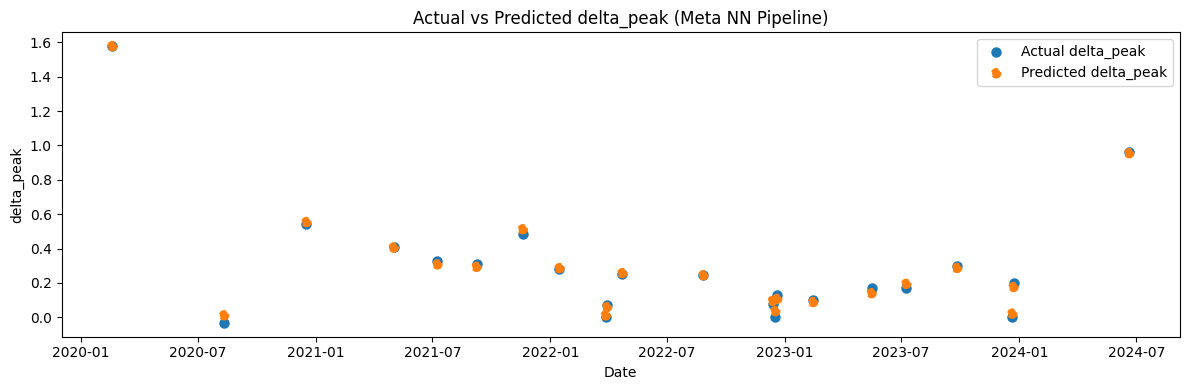

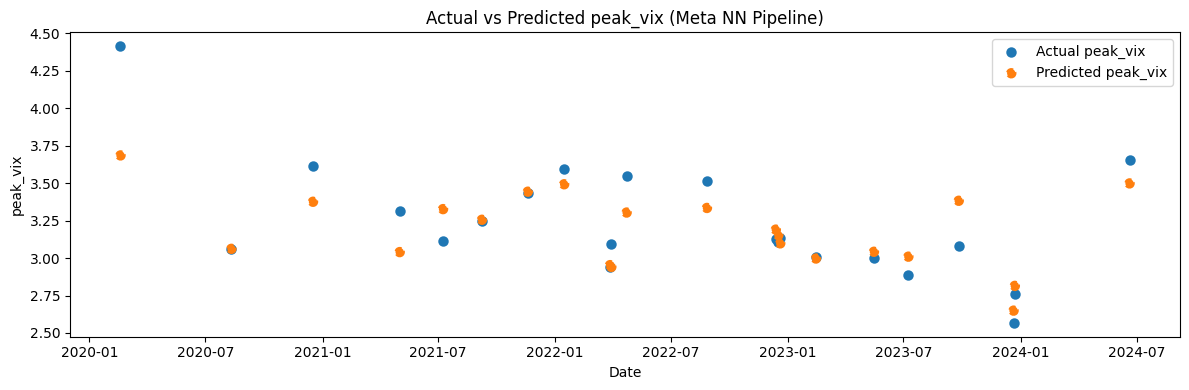

In [ ]:
# 1) EXACTLY the same meta‐feature lists as in training
excluded = {"peak_vix", "delta_peak", "T_up", "T_half", 'spike5d'}

meta_features_delta = [
    col for col in arc_df_with_nn.columns
    if col not in excluded and (col.startswith("nn_") or col.startswith("xgb_delta_peak"))
]
meta_features_peak = [
    col for col in arc_df_with_nn.columns
    if col not in excluded and col.startswith("nn_")
]

# 2) Build X & y
dates        = arc_df_with_nn.index
X_meta_delta = arc_df_with_nn[meta_features_delta].values
y_true_delta = arc_df_with_nn["delta_peak"].values
X_meta_peak  = arc_df_with_nn[meta_features_peak].values
y_true_peak  = arc_df_with_nn["peak_vix"].values

# 3) Load the full pipelines you trained & saved
delta_pipe = joblib.load("meta_delta_pipe.pkl")
peak_pipe  = joblib.load("meta_peak_pipe.pkl")

# 4) Predict (scaling happens automatically inside the pipeline)
y_pred_delta = delta_pipe.predict(X_meta_delta)
y_pred_peak  = peak_pipe.predict(X_meta_peak)

# 5) Plot exactly as before...
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.scatter(dates, y_true_delta, label="Actual delta_peak", linewidth=1.5)
plt.scatter(dates, y_pred_delta, label="Predicted delta_peak", linestyle="--", linewidth=1.5)
plt.title("Actual vs Predicted delta_peak (Meta NN Pipeline)")
plt.xlabel("Date"); plt.ylabel("delta_peak")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 4))
plt.scatter(dates, y_true_peak, label="Actual peak_vix", linewidth=1.5)
plt.scatter(dates, y_pred_peak, label="Predicted peak_vix", linestyle="--", linewidth=1.5)
plt.title("Actual vs Predicted peak_vix (Meta NN Pipeline)")
plt.xlabel("Date"); plt.ylabel("peak_vix")
plt.legend(); plt.tight_layout(); plt.show()


# Test Set on models (regime + panic probability)


In [137]:
vix_windows_df_train.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2019-05-24,2.768204,2.766948,2.726545,2.731115,2.662355,2.725235,2.789937,2.785628,2.586259,2.567254,...,2.694627,2.536075,2.496506,2.695978,2.598979,2.516890,2.553344,2.553344,2.553344,NaN
2019-06-12,2.726545,2.731115,2.662355,2.725235,2.789937,2.785628,2.586259,2.567254,2.559550,2.604909,...,2.496506,2.695978,2.598979,2.516890,2.553344,2.553344,2.553344,2.558002,2.563410,NaN
2020-02-19,2.837908,3.326833,3.509154,3.736240,3.856510,3.987131,4.415099,4.276666,4.190261,4.158102,...,3.448717,3.360723,3.252311,3.242202,3.259634,3.275634,3.251537,3.324316,3.324316,0.7075
2020-08-11,3.093313,3.061052,3.068518,3.115292,3.107721,3.147165,3.262701,3.514526,3.448717,3.360723,...,3.480009,3.507058,3.695855,3.626738,3.638112,3.614425,3.614425,3.614425,3.570940,NaN
2020-08-21,3.107721,3.147165,3.262701,3.514526,3.448717,3.360723,3.252311,3.242202,3.259634,3.275634,...,3.638112,3.614425,3.614425,3.614425,3.570940,3.386760,3.317091,3.213260,3.248435,NaN


In [138]:
print(results.params)

p[0->0]     0.975581
p[1->0]     0.029384
const[0]   -0.653526
const[1]    0.560605
x1[0]       0.040080
x1[1]      -0.109190
x2[0]      -0.053259
x2[1]       0.131607
sigma2      0.299374
dtype: float64


In [225]:
per_markov_test = 0.01
# 1. After fitting on training set
train_params = results.params
k=2

X_test = test_df[selected_features]
y_test = test_df['vix_ewm_zscore']

# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=k,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
if k == 3:
    test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities.idxmax(axis=1)
    test_df['regime_t'] = test_df['regime_t_raw'].apply(lambda r: 1 if r in [2] else 0) #[1,2]
else:
    test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]
    test_df['regime_t'] = test_df['regime_t_raw'].apply(lambda p: 1 if p >= per_markov_test else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)



c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\dsuni\AppData\Local\Temp\ipykernel_21156\2010485861.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]
C:\Users\dsuni\AppData\Local\Temp\ipykernel_21156\2010485861.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [226]:
test_df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426,0.002044,0,0.649876,3.185112
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944,0.001323,0,0.781374,3.206803
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161,0.002020,0,0.438179,3.202746
2025-05-01,-0.214649,-0.976830,256,-0.123903,-0.974128,371,189,-0.169276,-0.975479,675,...,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348,0.002190,0,0.712098,3.121483
2025-05-02,-0.053660,-0.976696,177,-0.039443,-0.973332,387,147,-0.046552,-0.975014,744,...,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362,0.000781,0,0.666338,NaN


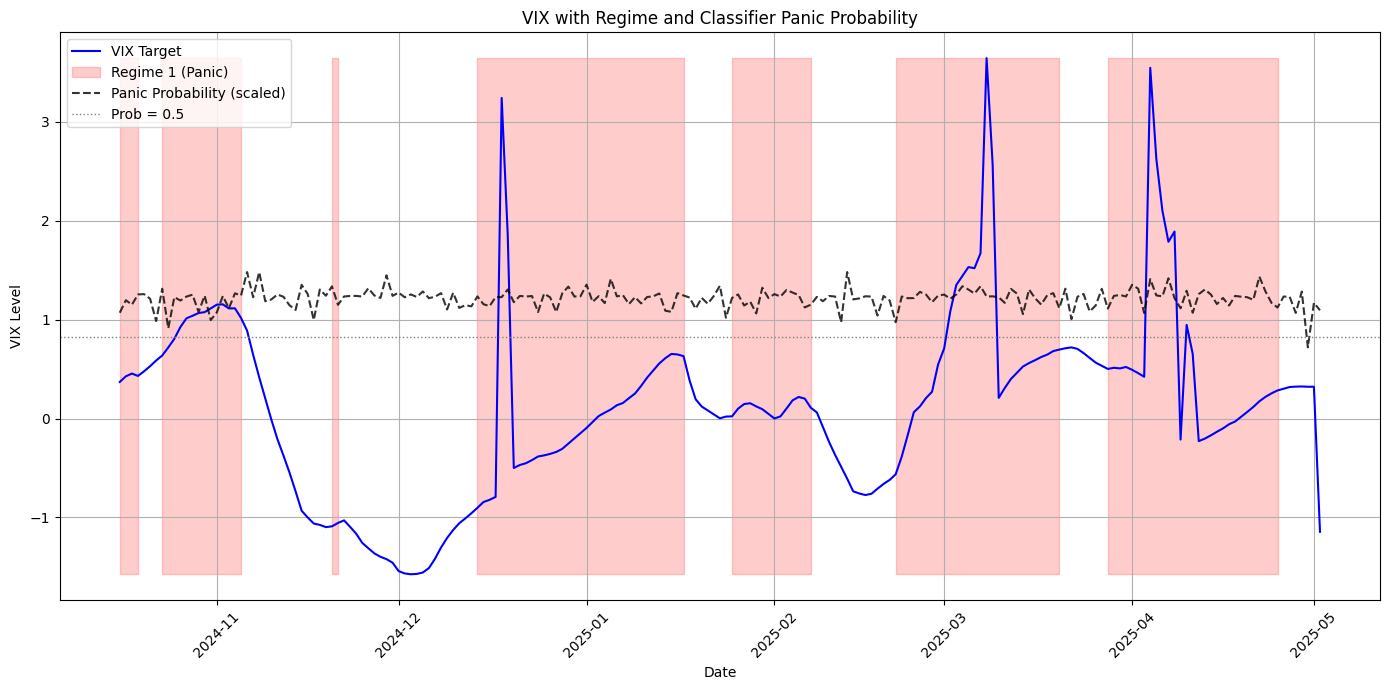

In [227]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_ewm_zscore_flat"], label="VIX Target", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_ewm_zscore_flat"].min(),
    test_df["vix_ewm_zscore_flat"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_ewm_zscore_flat"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_ewm_zscore_flat"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

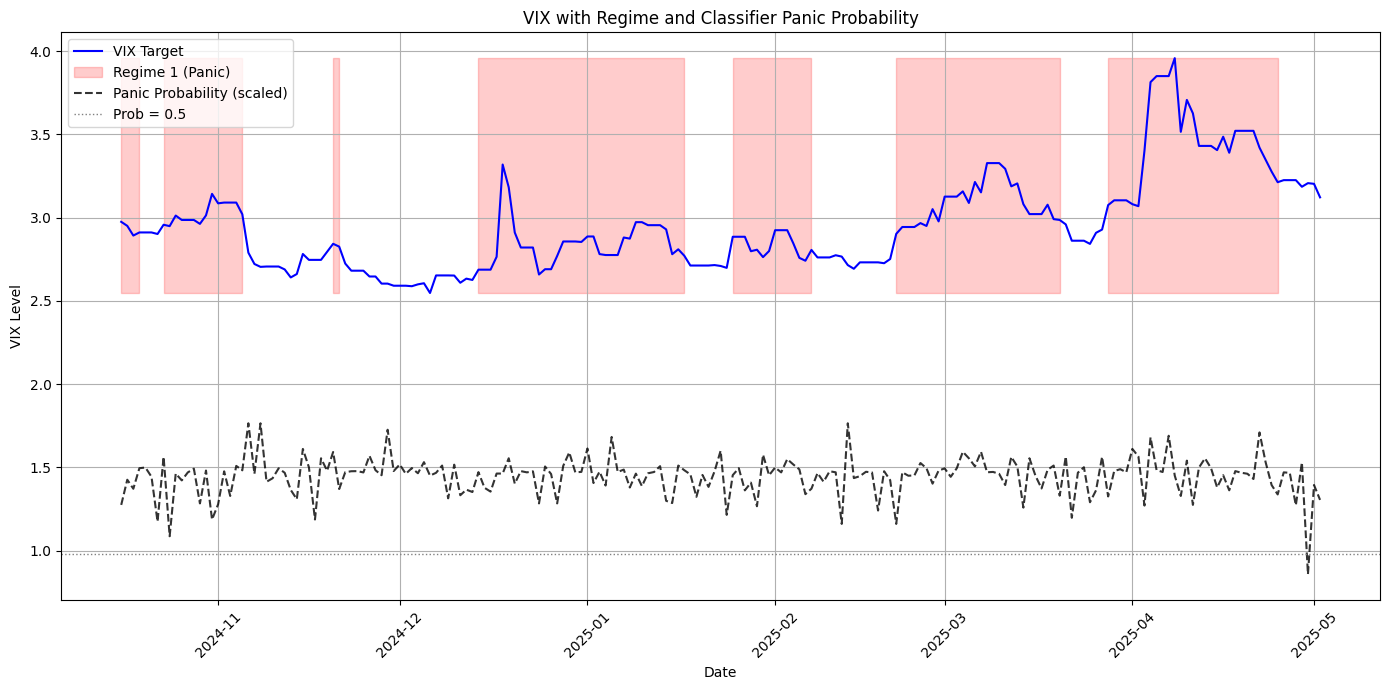

In [228]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target"], label="VIX Target", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target"].min(),
    test_df["vix_target"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [229]:
arc_df_test

NameError: name 'arc_df_test' is not defined

In [230]:
test_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,0.109050,18.521333,18.521333,18.115315,1.097978,0.369787,0.591054,1,0.650984,2.950212
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,-0.091281,18.602667,18.602667,18.146757,1.068928,0.426511,0.495364,1,0.728226,2.892037
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,-0.549641,18.652667,18.652667,18.179396,1.041571,0.454381,0.078373,1,0.700537,2.910719
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,-0.379178,18.646000,18.646000,18.209500,1.014136,0.430416,0.020657,1,0.763590,2.910719
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,-0.364995,18.714000,18.714000,18.242048,0.988944,0.477228,0.009278,0,0.765677,2.910719


In [231]:
classification_df_test = macro_utils.identify_sustained_regimes_and_transitions(test_df)

c:\Users\dsuni\Documents\GitHub\VIXNLP\VIXNLP\finnhub_news\macro_utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['regime_group'] = (classification_df['regime_t'] != classification_df['regime_t'].shift()).cumsum()
c:\Users\dsuni\Documents\GitHub\VIXNLP\VIXNLP\finnhub_news\macro_utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['is_sustained_regime1'] = classification_df['regime_group'].isin(valid_groups)
c:\Users\dsuni\Documents\GitHub\VIXNLP\VIXNLP\f

In [232]:
classification_df_test

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,1.097978,0.369787,0.591054,1,0.650984,2.950212,1,True,NaN,False
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,1.068928,0.426511,0.495364,1,0.728226,2.892037,1,True,1.0,False
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,1.041571,0.454381,0.078373,1,0.700537,2.910719,1,True,1.0,False
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,1.014136,0.430416,0.020657,1,0.763590,2.910719,1,True,1.0,False
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,0.988944,0.477228,0.009278,0,0.765677,2.910719,2,False,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,6.950796,0.322426,0.002044,0,0.649876,3.185112,14,False,0.0,False
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,6.748147,0.323944,0.001323,0,0.781374,3.206803,14,False,0.0,False
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,6.550984,0.321161,0.002020,0,0.438179,3.202746,14,False,0.0,False


In [403]:
result = macro_utils.transform_vix_data(classification_df_test, window=60, test=True, k=2)
vix_windows_df_test = result["vix_windows_df_train"]
regime_windows_df_test = result["regime_windows_df_train"]
vix_windows_past_df_test = result["vix_windows_past_df_train"]

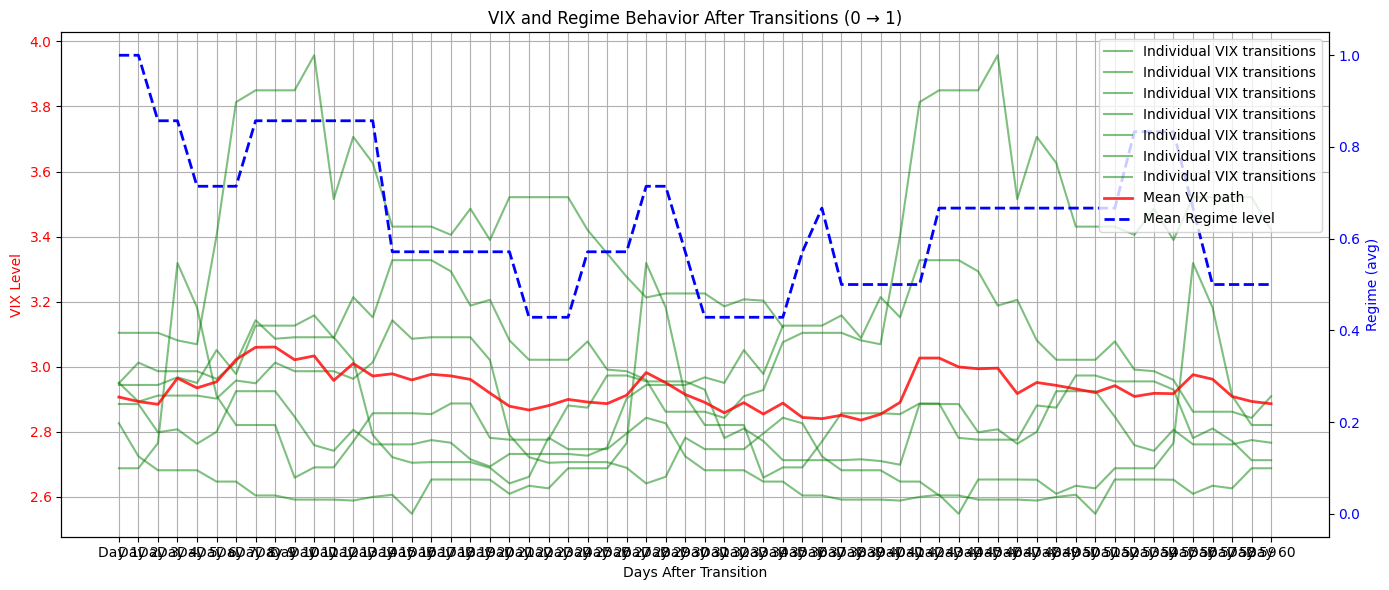

In [404]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_test.T, color="green", alpha=0.5, label="Individual VIX transitions")
ax1.plot(vix_windows_df_test.mean(axis=0).values, color="red",alpha=0.8, linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_test.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()


In [405]:
vix_windows_df_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-16,2.950212,2.892037,2.910719,2.910719,2.910719,2.901422,2.956991,2.948641,3.012098,2.985682,...,2.547099,2.652537,2.652537,2.652537,2.651833,2.608598,2.633327,2.625393,2.687167,2.687167
2024-10-23,2.948641,3.012098,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,...,2.625393,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188
2024-11-20,2.825537,2.723924,2.681022,2.681022,2.681022,2.646175,2.646175,2.603430,2.603430,2.590767,...,2.972464,2.954389,2.954389,2.954389,2.929058,2.780061,2.809403,2.770712,2.712042,2.712042
2024-12-14,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,...,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690
2025-01-25,2.884801,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,...,3.020913,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539
2025-02-21,2.943386,2.943386,2.943386,2.966818,2.949688,3.050694,2.977059,3.125883,3.125883,3.125883,...,3.430432,3.430432,3.405189,3.485539,3.389462,3.521052,3.521052,3.521052,3.521052,3.420019
2025-03-28,3.103689,3.103689,3.103689,3.080533,3.068518,3.401864,3.813528,3.849722,3.849722,3.849722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [406]:
df_delayed_spike_prob_test, test_clf, test_vix_pct_change_lookback_df = macro_utils.clf_delayed_spike_prob(vix_windows_df_test, test_df, "vix_target")

In [407]:
df_delayed_spike_prob_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-16,2.950212,2.892037,2.910719,2.910719,2.910719,2.901422,2.956991,2.948641,3.012098,2.985682,...,2.652537,2.652537,2.652537,2.651833,2.608598,2.633327,2.625393,2.687167,2.687167,NaN
2024-10-23,2.948641,3.012098,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,...,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,NaN
2024-11-20,2.825537,2.723924,2.681022,2.681022,2.681022,2.646175,2.646175,2.603430,2.603430,2.590767,...,2.954389,2.954389,2.954389,2.929058,2.780061,2.809403,2.770712,2.712042,2.712042,NaN
2024-12-14,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,...,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,0.8
2025-01-25,2.884801,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,...,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,NaN


In [408]:
test_vix_pct_change_lookback_df.head()

,Day -30,Day -29,Day -28,Day -27,Day -26,Day -25,Day -24,Day -23,Day -22,Day -21,...,Day -10,Day -9,Day -8,Day -7,Day -6,Day -5,Day -4,Day -3,Day -2,Day -1
2024-12-14,0.007754,0.045225,-0.012696,0.000000,0.0,0.017567,0.017305,-0.005996,-0.035963,-0.015750,...,0.004334,0.002566,-0.022470,0.041396,0.000000,0.0,-0.000266,-0.016304,0.009480,-0.003013
2025-02-21,0.000978,-0.001957,-0.004201,0.069237,0.0,0.000000,-0.030127,0.003252,-0.015836,0.013238,...,0.004780,-0.002937,-0.018439,-0.008140,0.014305,0.0,0.000000,0.000000,-0.001913,0.009252
2025-03-28,-0.005774,0.034243,-0.024137,0.049990,0.0,0.000000,0.010091,-0.022034,0.040742,-0.019358,...,0.018670,-0.028139,-0.001684,-0.008914,-0.033122,0.0,0.000000,-0.006662,0.023413,0.006687


In [409]:
df_delayed_spike_prob_test.loc[test_vix_pct_change_lookback_df.index, "early_spike_prob"] = clf_delayed_spike_prob.predict_proba(test_vix_pct_change_lookback_df)[:, 1]


In [410]:
df_delayed_spike_prob_test.fillna(0.5, inplace=True)

In [411]:
df_delayed_spike_prob_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-16,2.950212,2.892037,2.910719,2.910719,2.910719,2.901422,2.956991,2.948641,3.012098,2.985682,...,2.652537,2.652537,2.652537,2.651833,2.608598,2.633327,2.625393,2.687167,2.687167,0.5000
2024-10-23,2.948641,3.012098,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,...,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,0.5000
2024-11-20,2.825537,2.723924,2.681022,2.681022,2.681022,2.646175,2.646175,2.603430,2.603430,2.590767,...,2.954389,2.954389,2.954389,2.929058,2.780061,2.809403,2.770712,2.712042,2.712042,0.5000
2024-12-14,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,...,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,0.2125
2025-01-25,2.884801,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,...,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,0.5000
2025-02-21,2.943386,2.943386,2.943386,2.966818,2.949688,3.050694,2.977059,3.125883,3.125883,3.125883,...,3.430432,3.405189,3.485539,3.389462,3.521052,3.521052,3.521052,3.521052,3.420019,0.2300
2025-03-28,3.103689,3.103689,3.103689,3.080533,3.068518,3.401864,3.813528,3.849722,3.849722,3.849722,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.2175


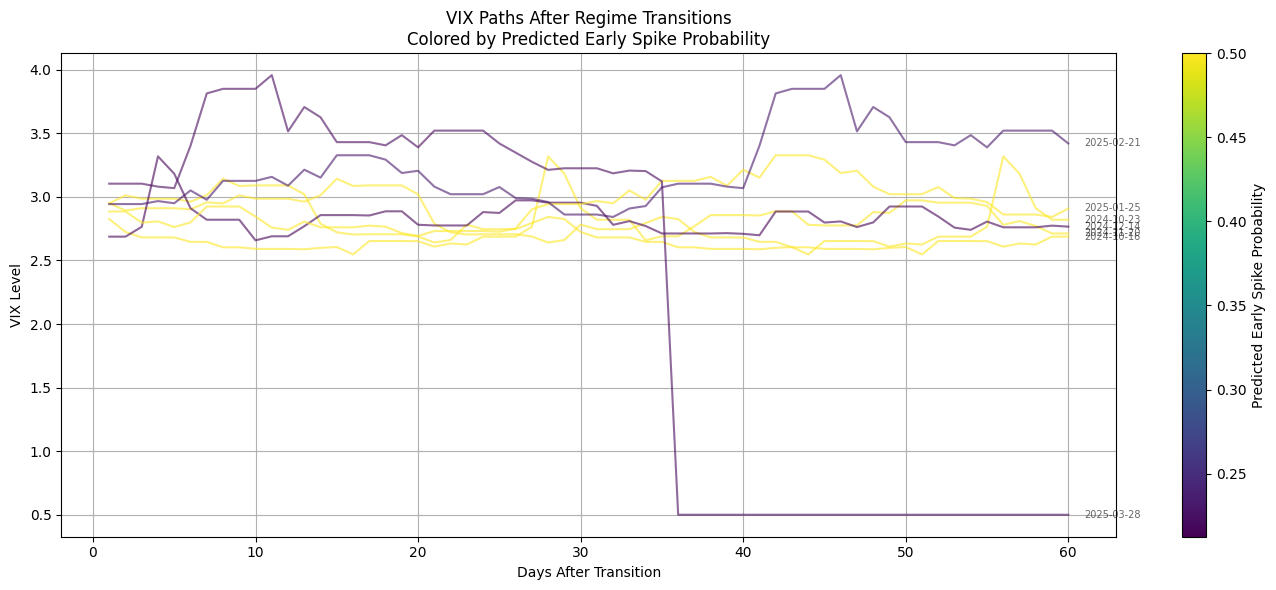

In [412]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob_test.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [413]:
df_delayed_spike_prob_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-16,2.950212,2.892037,2.910719,2.910719,2.910719,2.901422,2.956991,2.948641,3.012098,2.985682,...,2.652537,2.652537,2.652537,2.651833,2.608598,2.633327,2.625393,2.687167,2.687167,0.5000
2024-10-23,2.948641,3.012098,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,...,2.687167,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,0.5000
2024-11-20,2.825537,2.723924,2.681022,2.681022,2.681022,2.646175,2.646175,2.603430,2.603430,2.590767,...,2.954389,2.954389,2.954389,2.929058,2.780061,2.809403,2.770712,2.712042,2.712042,0.5000
2024-12-14,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,...,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,0.2125
2025-01-25,2.884801,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,...,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,0.5000


In [414]:
regime_windows_df_test = regime_windows_df_test.replace(2, 1)


In [415]:
regime_windows_df_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-16,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-10-23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-11-20,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2024-12-14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2025-01-25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2025-02-21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2025-03-28,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [416]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = test_df.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_test = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_test.index = pd.to_datetime(news_feats_test.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_test.index.min(),
                          news_feats_test.index.max(),
                          freq='D')

news_dense_test = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



In [417]:
# ------------------------------------------------------------
# 3)  BUILD ARC-LEVEL TABLE  (robust to missing news dates + look-back stats)
# ------------------------------------------------------------
records = []
lookback_days = [2, 5, 7]
lookback_feats = [
    "shock_neg",
    "vix_zscore",
    "vix_target",
    "sentiment_dominance",
]

for dt, row in vix_windows_df_test.iterrows():
    # --- detect arc in the 60-day window ---
    v = row[[f"Day {i}" for i in range(1, 61)]].values
    r = regime_windows_df_test.loc[dt, [f"Day {i}" for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur = peak_idx - start_idx
    decay_idx = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest-past news features --------
    try:
        feats_on_start = news_dense_test.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    # -------- compute look-back statistics from classification_df --------
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df_test.loc[start_date:dt_norm]

        for feat in lookback_feats:
            col_mean = window_df[feat].mean()
            col_std = window_df[feat].std()
            # percent change over the window: (last−first) / first
            if len(window_df) > 1 and window_df[feat].iloc[0] != 0:
                col_pct = (window_df[feat].iloc[-1] - window_df[feat].iloc[0]) / window_df[feat].iloc[0]
            else:
                col_pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"] = col_mean
            lookback_stats[f"{feat}_std_{w}d"]  = col_std
            lookback_stats[f"{feat}_pctchg_{w}d"] = col_pct

    # --- aggregate everything into one record ---
    records.append({
        "date_start":    dt_norm,
        "peak_vix":      peak_val,
        "vix0":          start_val,
        "T_up":          rise_dur,
        "T_half":        half_life,
        **feats_on_start,
        **lookback_stats,
    })

arc_df_test = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)


arc_df shape: (22, 70)


c:\Users\dsuni\Documents\GitHub\VIXNLP\VIXNLP\finnhub_news\macro_utils.py:371: RuntimeWarning: invalid value encountered in cast
  r = np.asarray(regime_path, dtype=np.int8)


In [418]:
arc_df_test.tail()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,shock_neg_pctchg_7d,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-11-20,2.723924,2.825537,1.0,59.0,-0.033441,-0.974451,53.0,0.014901,-0.973305,105.0,...,0.000348,-0.972874,0.493275,-0.847446,2.744690,0.066817,0.076538,33.875,17.963753,0.538462
2024-12-14,3.318540,2.687167,3.0,57.0,-0.078451,-0.957540,22.0,-0.030820,-0.951946,65.0,...,-0.009575,-0.358069,0.283013,-1.605554,2.645491,0.023419,0.013055,63.125,29.112773,-0.220000
2025-01-25,2.924236,2.884801,6.0,54.0,0.117867,-0.971038,7.0,0.201732,-0.680292,15.0,...,-0.122846,-0.979089,0.654743,-1.455344,2.731881,0.062000,0.063700,8.500,15.212777,-0.454545
2025-02-21,3.327192,2.943386,14.0,46.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,0.002167,-0.451964,0.837399,-2.284270,2.749504,0.063693,0.077759,29.750,17.458113,-0.519231
2025-03-28,3.957570,3.103689,10.0,25.0,-0.162400,-0.970411,129.0,-0.077482,-0.974197,228.0,...,-0.001571,-1.087851,0.491524,-0.937639,2.911971,0.077219,0.039180,77.625,38.059868,-0.241758


In [419]:
arc_df_test.tail()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,shock_neg_pctchg_7d,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-11-20,2.723924,2.825537,1.0,59.0,-0.033441,-0.974451,53.0,0.014901,-0.973305,105.0,...,0.000348,-0.972874,0.493275,-0.847446,2.744690,0.066817,0.076538,33.875,17.963753,0.538462
2024-12-14,3.318540,2.687167,3.0,57.0,-0.078451,-0.957540,22.0,-0.030820,-0.951946,65.0,...,-0.009575,-0.358069,0.283013,-1.605554,2.645491,0.023419,0.013055,63.125,29.112773,-0.220000
2025-01-25,2.924236,2.884801,6.0,54.0,0.117867,-0.971038,7.0,0.201732,-0.680292,15.0,...,-0.122846,-0.979089,0.654743,-1.455344,2.731881,0.062000,0.063700,8.500,15.212777,-0.454545
2025-02-21,3.327192,2.943386,14.0,46.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,0.002167,-0.451964,0.837399,-2.284270,2.749504,0.063693,0.077759,29.750,17.458113,-0.519231
2025-03-28,3.957570,3.103689,10.0,25.0,-0.162400,-0.970411,129.0,-0.077482,-0.974197,228.0,...,-0.001571,-1.087851,0.491524,-0.937639,2.911971,0.077219,0.039180,77.625,38.059868,-0.241758


In [420]:
arc_df_test['early_spike_prob'] = vix_windows_df_test['early_spike_prob'].fillna(0.5)

In [421]:
# Get column sets
cols_arc_df = set(arc_df.columns)
cols_arc_df_test = set(arc_df_test.columns)

# Columns in arc_df but NOT in arc_df_test
diff_arc_not_test = cols_arc_df - cols_arc_df_test

# Columns in arc_df_test but NOT in arc_df
diff_test_not_arc = cols_arc_df_test - cols_arc_df

# All differing columns
diff_all = cols_arc_df.symmetric_difference(cols_arc_df_test)

# Print results
print("Columns in arc_df but not in arc_df_test:", diff_arc_not_test)
print("Columns in arc_df_test but not in arc_df:", diff_test_not_arc)
print("All differing columns:", diff_all)


Columns in arc_df but not in arc_df_test: {'spike5d', 'delta_peak'}
Columns in arc_df_test but not in arc_df: {'regime_group', 'regime_t-1', 'is_sustained_regime1', 'panic_prob_t+1', 'vix_target', 'is_transition', 'vix_target_t+1', 'regime_t_raw', 'regime_t'}
All differing columns: {'vix_target_t+1', 'spike5d', 'regime_t_raw', 'regime_group', 'regime_t-1', 'delta_peak', 'is_sustained_regime1', 'is_transition', 'regime_t', 'panic_prob_t+1', 'vix_target'}


In [422]:
arc_df_test.drop(columns=diff_test_not_arc, inplace=True)

In [423]:
#arc_df_test['peak_vix'].iloc[-1] = np.log(55)

In [424]:
arc_df_test.iloc[-1]

peak_vix                          3.957570
vix0                              3.103689
T_up                             10.000000
T_half                           25.000000
summary_mean                     -0.162400
                                   ...    
vix_target_pctchg_7d              0.039180
sentiment_dominance_mean_7d      77.625000
sentiment_dominance_std_7d       38.059868
sentiment_dominance_pctchg_7d    -0.241758
early_spike_prob                  0.217500
Name: 2025-03-28 00:00:00, Length: 68, dtype: float64

In [425]:
feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half", 'spike5d', 'delta_peak'])


In [426]:
arc_df_test['early_spike_prob'] = arc_df_test['early_spike_prob'].fillna(0.5)

In [427]:
print(list(feature_cols))
print(list(arc_df_test.reindex(columns=feature_cols).columns))


['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_mean_flat', 'ewm_std', 'ewm_std_flat', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_prev', 'mean_sentiment_decay', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d', 'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d', 'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d', 'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d', 'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d', 'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d', 'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d', 'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_ewm_zscore_flat', 'vix_flat_abs', 'vix_target_mean_2d', 'vix_target_mean_5d', 'vix_target_

In [428]:
arc_df_test.iloc[-1]

peak_vix                          3.957570
vix0                              3.103689
T_up                             10.000000
T_half                           25.000000
summary_mean                     -0.162400
                                   ...    
vix_target_pctchg_7d              0.039180
sentiment_dominance_mean_7d      77.625000
sentiment_dominance_std_7d       38.059868
sentiment_dominance_pctchg_7d    -0.241758
early_spike_prob                  0.217500
Name: 2025-03-28 00:00:00, Length: 68, dtype: float64

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


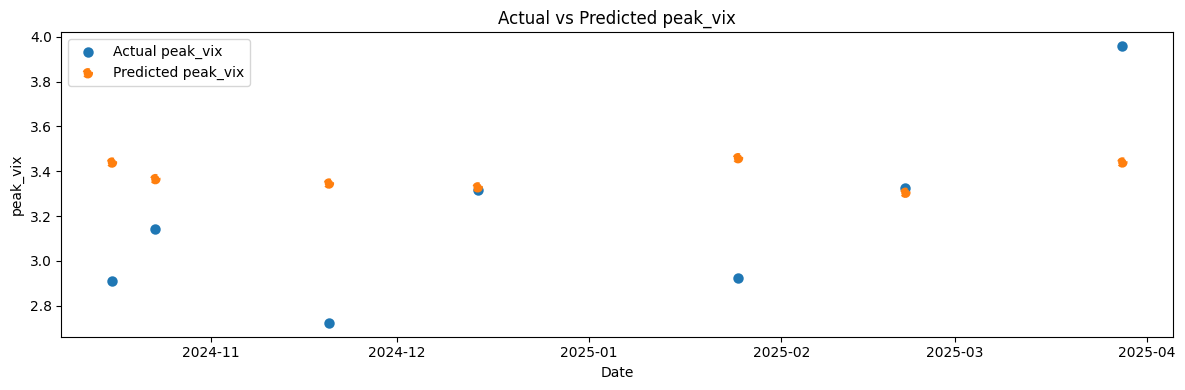

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


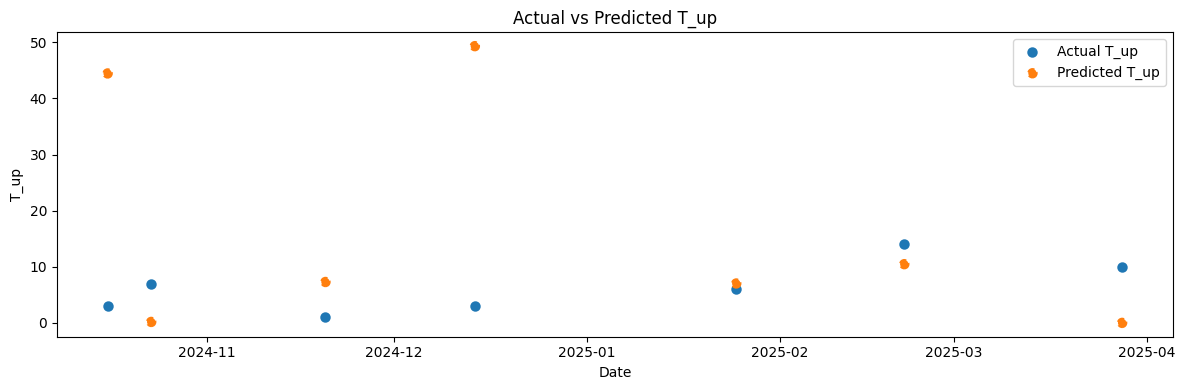

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


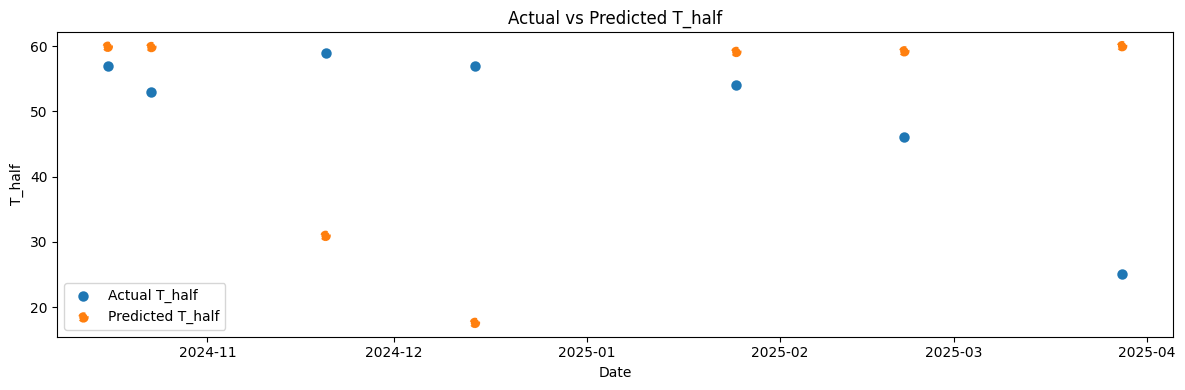

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


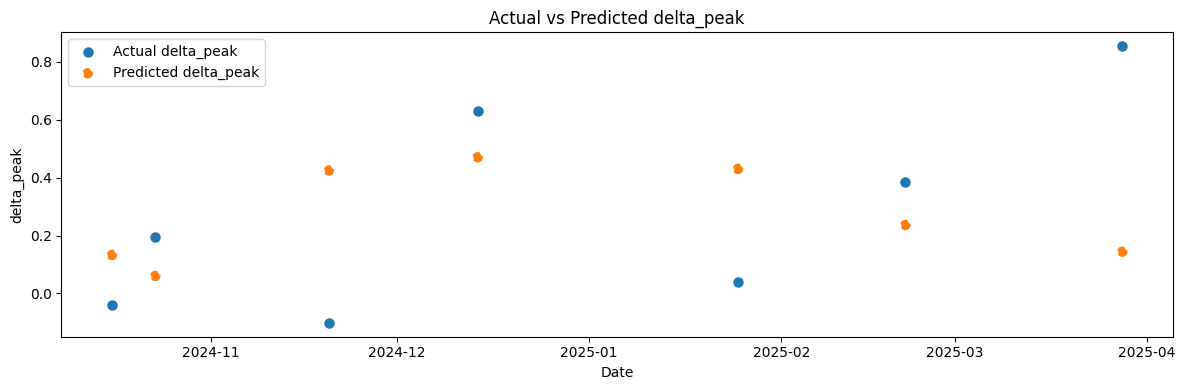

In [429]:
import joblib, matplotlib.pyplot as plt
arc_df_test['delta_peak'] = arc_df_test['peak_vix'] - arc_df_test['vix0']
arc_df_test["spike5d"] = (arc_df_test["delta_peak"] > 0.1 * arc_df_test["vix0"]).astype(int)

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half", "delta_peak", "spike5d"])

X_full_test = arc_df_test.reindex(columns=feature_cols)
X_full_test = X_full_test.fillna(0)

dates = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# XGBoost graph

# RECENT/TRADE

In [430]:
arc_df_test.head()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-16,2.910719,2.950212,3.0,57.0,-0.222685,-0.976018,47.0,-0.167496,-0.971121,51.0,...,NaN,2.974509,NaN,NaN,-3.000,NaN,NaN,0.5000,-0.039493,0
2024-10-23,3.142427,2.948641,7.0,53.0,-0.157935,-0.975736,40.0,-0.038889,-0.971612,60.0,...,-0.787686,2.925916,0.030137,-0.005889,2.875,10.260013,-3.000000,0.5000,0.193786,0
2024-11-20,2.723924,2.825537,1.0,59.0,-0.033441,-0.974451,53.0,0.014901,-0.973305,105.0,...,-0.847446,2.744690,0.066817,0.076538,33.875,17.963753,0.538462,0.5000,-0.101613,0
2024-12-14,3.318540,2.687167,3.0,57.0,-0.078451,-0.957540,22.0,-0.030820,-0.951946,65.0,...,-1.605554,2.645491,0.023419,0.013055,63.125,29.112773,-0.220000,0.2125,0.631373,1
2025-01-25,2.924236,2.884801,6.0,54.0,0.117867,-0.971038,7.0,0.201732,-0.680292,15.0,...,-1.455344,2.731881,0.062000,0.063700,8.500,15.212777,-0.454545,0.5000,0.039436,0


In [431]:
test_df_trade

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,0.016615,0.412830,19.328083,2.310096,0.109050,18.521333,18.521333,18.115315,1.097978,0.369787
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,0.011111,0.193659,19.314014,2.234998,-0.091281,18.602667,18.602667,18.146757,1.068928,0.426511
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,-0.120059,-0.260678,19.231174,2.185379,-0.549641,18.652667,18.652667,18.179396,1.041571,0.454381
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,-0.043727,-0.148076,19.175615,2.124632,-0.379178,18.646000,18.646000,18.209500,1.014136,0.430416
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,-0.188604,-0.183860,19.123639,2.064789,-0.364995,18.714000,18.714000,18.242048,0.988944,0.477228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161


In [432]:
def get_past_60_trading_days(df, target_date):
    """
    Given a DataFrame with a DatetimeIndex and a target date (string or datetime),
    return the 60 trading days *before* that date (exclusive).
    """
    # Ensure datetime format
    target_date = pd.to_datetime(target_date)
    
    # Filter to dates strictly before the target date
    df_before = df[df.index < target_date]
    
    # Get last 60 rows before the target date
    return df_before.tail(61)


In [433]:
df_trade = get_past_60_trading_days(test_df_trade, "2025-04-01")

In [434]:
df_trade.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-03-27,-0.116046,-0.972738,97,-0.160304,-0.974677,190,97,-0.138175,-0.973707,380,...,-0.228642,-0.946713,20.110244,3.276012,-0.433528,21.753333,21.753333,20.397050,2.547062,0.532490
2025-03-28,-0.162400,-0.970411,129,-0.077482,-0.974197,228,99,-0.119941,-0.972304,426,...,-0.122060,-0.051610,20.209583,3.191845,0.451280,21.728667,21.728667,20.482960,2.485897,0.501109
2025-03-29,-0.108121,-0.975388,41,-0.056513,-0.963759,82,30,-0.082317,-0.969573,153,...,0.023427,0.135032,20.343158,3.130212,0.618758,21.813667,21.813667,20.568812,2.427252,0.512866
2025-03-30,-0.097622,-0.971186,35,-0.115972,-0.968847,83,34,-0.106797,-0.970017,165,...,0.086299,0.108093,20.468116,3.065991,0.590962,21.852000,21.852000,20.651599,2.369442,0.506618
2025-03-31,-0.105202,-0.976278,101,-0.092809,-0.974719,217,86,-0.099005,-0.975499,419,...,0.086299,0.113515,20.585011,2.999800,0.565034,21.940334,21.940334,20.734743,2.314248,0.520943


In [435]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data

X_test = df_trade[selected_features]
y_test = df_trade['vix_ewm_zscore']


In [436]:
X_test.tail()

,shock_neg,dominance_trigger
date,,
2025-03-27,-0.973707,0
2025-03-28,-0.972304,0
2025-03-29,-0.969573,0
2025-03-30,-0.970017,0
2025-03-31,-0.975499,0


In [437]:
# 3. Define same model on test data
model_trade = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=2
    ,
    switching_variance=False
)

c:\Users\dsuni\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [438]:
results_test = model_trade.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
df_trade['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]
df_trade['regime_t'] = df_trade['regime_t_raw'].apply(lambda r: 1 if r > percentile_markov else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
df_trade['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

In [439]:
df_trade.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1
date,,,,,,,,,,,,,,,,,,,,,
2025-03-27,-0.116046,-0.972738,97,-0.160304,-0.974677,190,97,-0.138175,-0.973707,380,...,3.276012,-0.433528,21.753333,21.753333,20.397050,2.547062,0.532490,0.004003,1,0.798313
2025-03-28,-0.162400,-0.970411,129,-0.077482,-0.974197,228,99,-0.119941,-0.972304,426,...,3.191845,0.451280,21.728667,21.728667,20.482960,2.485897,0.501109,0.192757,1,0.676864
2025-03-29,-0.108121,-0.975388,41,-0.056513,-0.963759,82,30,-0.082317,-0.969573,153,...,3.130212,0.618758,21.813667,21.813667,20.568812,2.427252,0.512866,0.820990,1,0.754892
2025-03-30,-0.097622,-0.971186,35,-0.115972,-0.968847,83,34,-0.106797,-0.970017,165,...,3.065991,0.590962,21.852000,21.852000,20.651599,2.369442,0.506618,0.984254,1,0.760545
2025-03-31,-0.105202,-0.976278,101,-0.092809,-0.974719,217,86,-0.099005,-0.975499,419,...,2.999800,0.565034,21.940334,21.940334,20.734743,2.314248,0.520943,0.996652,1,0.751085


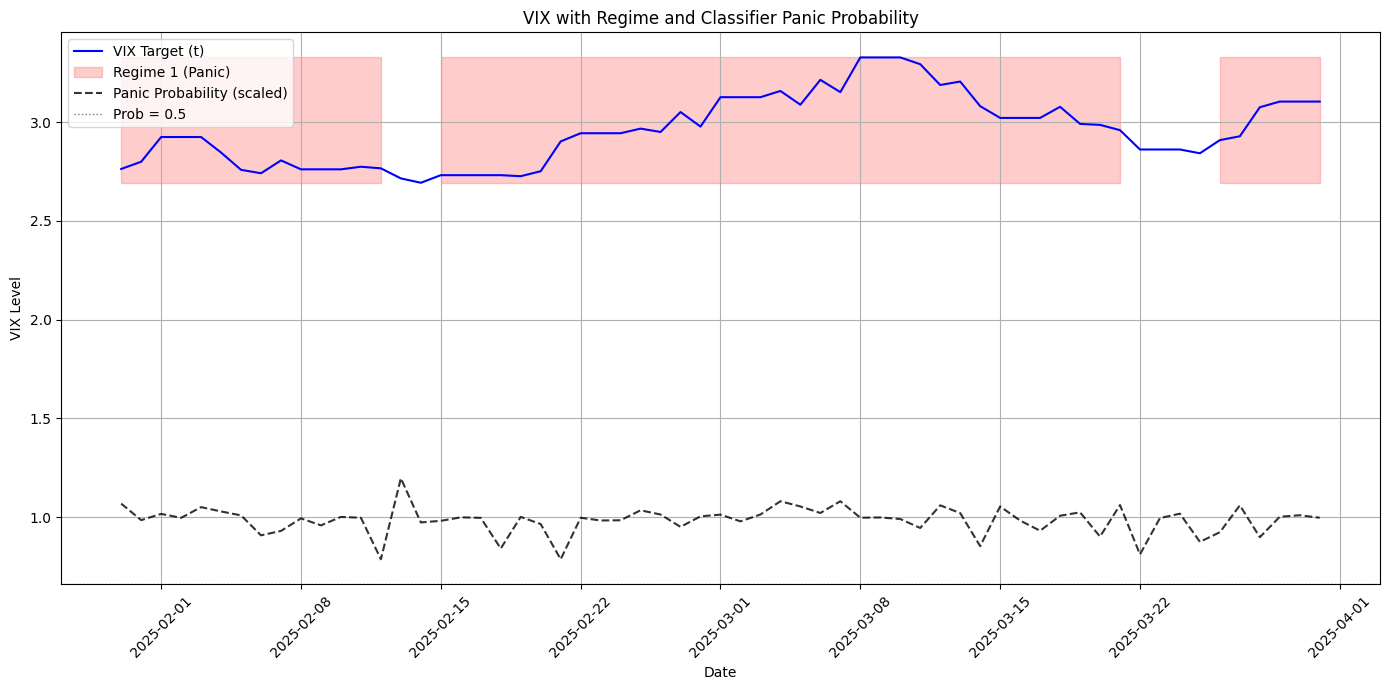

In [440]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(df_trade.index, df_trade["vix_target"], label="VIX Target (t)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    df_trade.index,
    df_trade["vix_target"].min(),
    df_trade["vix_target"].max(),
    where=df_trade["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = df_trade["panic_prob_t+1"] * (df_trade["vix_target"].max() - 2)
plt.plot(df_trade.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (df_trade["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [441]:
classification_df_trade = macro_utils.identify_sustained_regimes_and_transitions(df_trade, trade = True)

In [442]:
classification_df_trade.shape

(61, 33)

In [137]:
result_trade = macro_utils.transform_vix_data(classification_df_trade, window=50, trade = True, k=2)
vix_windows_past_df_trade = result_trade["vix_windows_past_df_train"]

In [138]:
vix_windows_past_df_trade

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 41,Day 42,Day 43,Day 44,Day 45,Day 46,Day 47,Day 48,Day 49,Day 50
transition_time,,,,,,,,,,,,,,,,,,,,,
2025-03-28,2.74084,2.805782,2.760643,2.760643,2.760643,2.773838,2.76569,2.714695,2.692598,2.731115,...,3.077312,2.99072,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,2.927989


In [139]:
from macro_utils import calculate_pct_changes

# Get current date (your live transition point — usually last row in trade DF)
live_index = classification_df_trade[classification_df_trade["is_transition"]].index[-1:]
print(f"✅ Using live index: {live_index}")

# Calculate past % changes from historical VIX column
vix_pct_change_lookback_df_trade, used_indices = calculate_pct_changes(
    df_model=classification_df_trade,
    valid_indices=live_index,
    lookback=30,
    vix_column="vix_target"
)

# Now predict with  classifier
early_spike_prob_trade = clf_delayed_spike_prob.predict_proba(vix_pct_change_lookback_df_trade)[0][1]
print(f"🟢 Early spike probability: {early_spike_prob_trade:.2%}")


✅ Using live index: DatetimeIndex(['2025-03-28'], dtype='datetime64[ns]', name='date', freq=None)
🟢 Early spike probability: 48.25%


In [140]:
vix_pct_change_lookback_df_trade.head()

,Day -30,Day -29,Day -28,Day -27,Day -26,Day -25,Day -24,Day -23,Day -22,Day -21,...,Day -10,Day -9,Day -8,Day -7,Day -6,Day -5,Day -4,Day -3,Day -2,Day -1
2025-03-28,-0.005774,0.034243,-0.024137,0.04999,0.0,0.0,0.010091,-0.022034,0.040742,-0.019358,...,0.01867,-0.028139,-0.001684,-0.008914,-0.033122,0.0,0.0,-0.006662,0.023413,0.006687


In [141]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = df_trade.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_trade = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_trade.index = pd.to_datetime(news_feats_trade.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_trade.index.min(),
                          news_feats_trade.index.max(),
                          freq='D')

news_dense_trade = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)

In [142]:
news_dense_trade.columns

Index(['summary_mean', 'summary_min', 'summary_neg_count', 'headline_mean',
       'headline_min', 'headline_pos_count', 'headline_neg_count',
       'overall_mean', 'overall_min', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'ewm_mean', 'ewm_std', 'vix_ewm_zscore', 'mean_prev', 'vix_flat_abs',
       'ewm_mean_flat', 'ewm_std_flat', 'vix_ewm_zscore_flat', 'regime_t_raw',
       'regime_t', 'panic_prob_t+1', 'vix_target_t+1', 'regime_group',
       'is_sustained_regime1', 'regime_t-1', 'is_transition', 'dom_0',
       'dom_1'],
      dtype='object')

In [143]:
feature_cols = feature_cols.drop(['date','date.1'], errors='ignore')


In [144]:
df_trade.columns

Index(['summary_mean', 'summary_min', 'summary_neg_count', 'headline_mean',
       'headline_min', 'headline_pos_count', 'headline_neg_count',
       'overall_mean', 'overall_min', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'ewm_mean', 'ewm_std', 'vix_ewm_zscore', 'mean_prev', 'vix_flat_abs',
       'ewm_mean_flat', 'ewm_std_flat', 'vix_ewm_zscore_flat', 'regime_t_raw',
       'regime_t', 'panic_prob_t+1', 'regime_group', 'is_sustained_regime1',
       'regime_t-1', 'is_transition'],
      dtype='object')

In [145]:
def build_live_arc_row(start_idx,
                       news_dense,
                       classification_df_trade,
                       feature_cols,
                       lookback_days=(2, 5, 7),
                       lookback_feats=("shock_neg", "vix_zscore", "vix_target", "sentiment_dominance")):
    """
    Build one live-arc row of features at timestamp `start_idx`.
    Returns a DataFrame with one row and columns exactly = feature_cols.
    """
    # normalize the timestamp
    dt_norm = pd.to_datetime(start_idx).normalize()

    # --- 1) grab the base row from classification_df_trade ---
    try:
        row = classification_df_trade.loc[[start_idx]].copy()
    except KeyError:
        print(f"❌ No classification data at {start_idx}")
        return None

    # --- 2) pull the latest news features (dropping any 'date' col) ---
    try:
        feats_on_start = (
            news_dense
            .loc[:dt_norm]
            .iloc[-1]
            .drop(labels=["date"], errors="ignore")
            .to_dict()
        )
    except IndexError:
        print(f"❌ No prior news available at {dt_norm}")
        return None

    # --- 3) one-hot encode the 'dominance_trigger' field ---
    dom_dummies = pd.get_dummies(row["dominance_trigger"], prefix="dom")
    # ensure both dom_0 and dom_1 exist
    for col in ("dom_0", "dom_1"):
        dom_dummies[col] = dom_dummies.get(col, 0)
    row = pd.concat([row, dom_dummies], axis=1)

    # --- 4) merge in the news features ---
    row = row.assign(**feats_on_start)

    # --- 5) drop any raw date columns to avoid leakage ---
    row = row.drop(columns=[c for c in row.columns if c.startswith("date")], errors="ignore")

    # --- 6) compute look-back stats for each window & feature ---
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df_trade.loc[start_date:dt_norm]

        for feat in lookback_feats:
            series = window_df.get(feat, pd.Series(dtype=float))
            m = series.mean()
            s = series.std()
            if len(series) > 1 and series.iloc[0] != 0:
                pct = (series.iloc[-1] - series.iloc[0]) / series.iloc[0]
            else:
                pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"]   = m
            lookback_stats[f"{feat}_std_{w}d"]    = s
            lookback_stats[f"{feat}_pctchg_{w}d"] = pct

    # merge lookback stats into row
    row = row.assign(**lookback_stats)

    # --- 7) finally, extract exactly the requested feature_cols (filling missing with 0) ---
    feature_values = {
        col: row[col].iloc[0] if col in row.columns else 0.0
        for col in feature_cols
    }
    arc_row = pd.DataFrame([feature_values], index=[start_idx])[feature_cols]
    return arc_row


In [146]:
start_idx = classification_df_trade[classification_df_trade["is_transition"]].index[-1]

# Build feature row
arc_row_live = build_live_arc_row(start_idx, news_dense_trade, classification_df_trade, feature_cols)


In [147]:
arc_row_live['early_spike_prob'] = early_spike_prob_trade

In [148]:
print(early_spike_prob_trade)

0.4825


In [149]:
if early_spike_prob_trade > 0.75:
    min_vix=df_trade['vix_target'].iloc[-20:].min()
    arc_row_live['vix0'] = min_vix
    print('<')
    print(min_vix)
else:
    min_vix=df_trade['vix_target'].iloc[-1:].min()
    arc_row_live['vix0'] = min_vix
    print(min_vix)


3.1036894458780013


In [150]:
print(arc_row_live['vix0'])

2025-03-28    3.103689
Name: vix0, dtype: float64


In [151]:
arc_row_live.columns

Index(['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean',
       'ewm_mean_flat', 'ewm_std', 'ewm_std_flat', 'headline_mean',
       'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_prev',
       'mean_sentiment_decay', 'overall_mean', 'overall_min',
       'overall_neg_count', 'overall_pos_count', 'sentiment_dominance',
       'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d',
       'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d',
       'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d',
       'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d',
       'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d',
       'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d',
       'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d',
       'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min',
       'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore'

In [152]:
import joblib
import pandas as pd

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
}


In [153]:
print(list(feature_cols))
print(list(arc_df_test.columns))
print(list(arc_row_live.columns))

['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_mean_flat', 'ewm_std', 'ewm_std_flat', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_prev', 'mean_sentiment_decay', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d', 'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d', 'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d', 'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d', 'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d', 'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d', 'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d', 'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_ewm_zscore_flat', 'vix_flat_abs', 'vix_target_mean_2d', 'vix_target_mean_5d', 'vix_target_

In [154]:
feature_cols = arc_df_test.columns.difference(["peak_vix", "T_up", "T_half", 'delta_peak', 'spike5d'])

In [155]:
arc_row_live = arc_row_live.reindex(columns=feature_cols)

In [156]:
arc_row_live['vix0']

2025-03-28    3.103689
Name: vix0, dtype: float64

In [157]:
arc_row_live['early_spike_prob'] = early_spike_prob_trade

In [158]:
print(early_spike_prob_trade)

0.4825


In [159]:
arc_row_live

,dom_0,dom_1,dominance_trigger,early_spike_prob,ewm_mean,ewm_mean_flat,ewm_std,ewm_std_flat,headline_mean,headline_min,...,vix_zscore,vix_zscore_mean_2d,vix_zscore_mean_5d,vix_zscore_mean_7d,vix_zscore_pctchg_2d,vix_zscore_pctchg_5d,vix_zscore_pctchg_7d,vix_zscore_std_2d,vix_zscore_std_5d,vix_zscore_std_7d
2025-03-28,True,False,0,0.4825,20.209583,20.48296,3.191845,2.485897,-0.077482,-0.974197,...,-0.05161,-0.690679,-1.066051,-1.087851,-0.951933,-0.964513,-0.937639,0.55708,0.541789,0.491524


In [160]:
arc_row_live.isna().sum()[arc_row_live.isna().sum() > 0]


Series([], dtype: int64)

In [161]:
arc_row_live['sentiment_dominance_pctchg_5d'] = arc_row_live['sentiment_dominance_pctchg_7d']

In [162]:
print(arc_row_live['vix0'])


2025-03-28    3.103689
Name: vix0, dtype: float64


In [163]:
X_full_test.iloc[1].equals(arc_row_live)


False

In [164]:
import pandas as pd

# initialize DataFrame with nn_-prefixed columns
live_preds_df = pd.DataFrame(columns=[f"nn_{t}" for t in models.keys()])

# — later, when you do your live predict:
if arc_row_live is not None:
    # predict and store under nn_<target> keys
    live_preds = {
        f"nn_{target}": float(models[target].predict(arc_row_live[feature_cols].values))
        for target in models
    }

    # append the new prediction as a row, indexed by the current date
    live_preds_df.loc[start_idx] = live_preds

    print(f"\n📍 Live prediction at {start_idx.date()}:")
    for target, val in live_preds.items():
        print(f"  {target:<12} → {val:.2f}")

    # (optional) view your accumulated predictions
    print("\nAll live preds so far:")
    print(live_preds_df)

else:
    print("❌ Failed to build input row.")



📍 Live prediction at 2025-03-28:
  nn_peak_vix  → 3.22
  nn_T_up      → 0.26
  nn_T_half    → 51.99
  nn_delta_peak → 0.22

All live preds so far:
            nn_peak_vix   nn_T_up  nn_T_half  nn_delta_peak
2025-03-28     3.219075  0.255486  51.986763       0.216294


C:\Users\dsuni\AppData\Local\Temp\ipykernel_15152\3192587301.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"nn_{target}": float(models[target].predict(arc_row_live[feature_cols].values))
C:\Users\dsuni\AppData\Local\Temp\ipykernel_15152\3192587301.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"nn_{target}": float(models[target].predict(arc_row_live[feature_cols].values))
C:\Users\dsuni\AppData\Local\Temp\ipykernel_15152\3192587301.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this ope

In [165]:
arc_df_with_nn_trade = arc_row_live.join(live_preds_df)


# XGB prediction

In [166]:
print(top_features)
#y_full_trade = arc_df_with_nn_trade[target_cols].values

['vix0', 'vix_target_mean_2d', 'vix_target_mean_5d', 'vix_target_mean_7d', 'shock_neg_pctchg_7d', 'sentiment_dominance_std_7d', 'headline_min', 'shock_neg_std_5d']


In [167]:
import joblib

# 1) Prepare your live feature DataFrame & result container
feature_cols    = arc_df_with_nn_trade.columns.difference(["T_up", "T_half", "peak_vix"])
X_full_trade    = arc_df_with_nn_trade[top_features].values     # will hold predictions

# 2) Define which quantiles you want
quantiles = [0.10, 0.50, 0.90]             # for example

# 3) Loop & predict
for q in quantiles:
    # load the saved quantile model
    model = joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    
    # generate predictions and store in your live DataFrame
    arc_df_with_nn_trade[f"xgb_delta_peak_q{q:.2f}"] = model.predict(X_full_trade)

# 4) (Optional) if you want a single point estimate, pick the median:
# live_preds_df["delta_peak_pred"] = live_preds_df["xgb_delta_peak_q0.50"]

# Now live_preds_df has your original features plus the 3 quantile columns
print(arc_df_with_nn_trade.filter(like="xgb_delta_peak").head())


            xgb_delta_peak_q0.10  xgb_delta_peak_q0.50  xgb_delta_peak_q0.90
2025-03-28              0.082876             -0.009256              0.183532


In [168]:
import joblib

# --- 1) Prepare your live DataFrame & feature sets ---
# arc_df_with_nn_trade must already be in your namespace

excluded = {"peak_vix", "delta_peak", "T_up", "T_half"}

# exactly the same meta‐feature definitions you used when training
meta_features_delta = [
    col for col in arc_df_with_nn_trade.columns
    if col not in excluded and (col.startswith("nn_") or col.startswith("xgb_delta_peak"))
]
meta_features_peak = [
    col for col in arc_df_with_nn_trade.columns
    if col not in excluded and col.startswith("nn_")
]

X_meta_delta_trade = arc_df_with_nn_trade[meta_features_delta].values
X_meta_peak_trade  = arc_df_with_nn_trade[meta_features_peak].values

# --- 2) Load your pre-trained pipelines (scaler + NN) ---
delta_pipe = joblib.load("meta_delta_pipe.pkl")
peak_pipe  = joblib.load("meta_peak_pipe.pkl")

# --- 3) Generate live predictions ---
arc_df_with_nn_trade["delta_peak_pred"] = delta_pipe.predict(X_meta_delta_trade)
arc_df_with_nn_trade["peak_vix_pred"]   = peak_pipe.predict(X_meta_peak_trade)

# --- 4) Inspect your new columns ---
print(arc_df_with_nn_trade[["delta_peak_pred", "peak_vix_pred"]].head())


            delta_peak_pred  peak_vix_pred
2025-03-28         0.403708       3.381439


In [169]:
print("vix starting point:")
print(np.exp(arc_df_with_nn_trade['vix0']))
print("vix predicted:")
print(np.exp(arc_df_with_nn_trade[["delta_peak_pred", "peak_vix_pred"]].head()))

vix starting point:
2025-03-28    22.280001
Name: vix0, dtype: float64
vix predicted:
            delta_peak_pred  peak_vix_pred
2025-03-28         1.497366      29.413073
